# BOF

In [249]:
import os
print(os.getcwd())
import gc
gc.collect()

import warnings
warnings.filterwarnings(action='ignore') # 'default'

import gc
gc.collect()

import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import tqdm_notebook

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import math
from sklearn.model_selection import train_test_split

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


np.random.seed(1234)

/Users/baesangjun/Desktop/DACON/빅콘/Before Model


In [326]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from tqdm import tqdm
from tqdm import tqdm_notebook

import math
import re
from itertools import product

from scipy import stats
from scipy.stats import gaussian_kde

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_samples, silhouette_score

import pickle

# 기본적인 처리와 대분류

In [327]:
data = pd.read_csv('data_v4_1_cost_filled.csv')

In [328]:
data.rename(columns={'골드':'gold',
                     '블루':'blue',
                     '그린':'green',
                     '노블':'noble',
                     '싹틔우미':'sprout',
                     '무료':'free',
                     'hour_cat':'timebomb'
                     }, inplace=True)

# Non Covid
data = data[data['covid']==0]

In [329]:
def get_dataset(data=data, booked_only=True, return_list=False):    
    if booked_only:
        df = data[data['cancel']==0]
    else:
        df = data.copy()
        
    # Psuedo Column
    df['all'] = 1

    # NA Indicator
    df.loc[df['gender'].isna(),'gender'] = 'N'
    
    
    # Fill NA : Age #

    # Mode
    df.loc[(df['member_yn']=='Y') & (df['age'].isna()),'age'] = 40.0

    # Noise
    df.loc[(df['noble']==1) & (df['age']==20.0),'age'] = 70.0
    df.loc[(df['noble']==1) & (df['age']==30.0),'age'] = 70.0
    df.loc[(df['noble']==1) & (df['age']==40.0),'age'] = 70.0
    df.loc[(df['noble']==1) & (df['age']==50.0),'age'] = 70.0
    df.loc[(df['noble']==1) & (df['age']==60.0),'age'] = 70.0

    df.loc[(df['sprout']==1) & (df['age']==80.0),'age'] = 20.0
    df.loc[(df['sprout']==1) & (df['age']==70.0),'age'] = 20.0
    df.loc[(df['sprout']==1) & (df['age']==60.0),'age'] = 20.0
    df.loc[(df['sprout']==1) & (df['age']==50.0),'age'] = 20.0
    df.loc[(df['sprout']==1) & (df['age']==40.0),'age'] = 20.0
    df.loc[(df['sprout']==1) & (df['age']==30.0),'age'] = 20.0
    
    df = df.fillna(-1)
    df['age'] = df['age'].astype(int)
    
    genre_map = {
        '교향곡':0,
        '클래식':1, '독주':1, '실내악':1, '재즈':1,
        '합창':2, '성악':2, '콘서트':2, '오페라':2, '기타':2, '복합장르':2, '크로스오버':2
    }
    df['split'] = df['genre'].replace(genre_map)
    df.insert(0, 'split', df.pop('split'))
    
    # Map timebomb
    tz_map = {
        'evening':0,
        'afternoon':1
    }
    df['timebomb'] = df['timebomb'].replace(tz_map)
        
    if return_list:
        data_van_list = []
        for c in range(3):
            data_van = df[df['split']==c].reset_index(drop=True)
            data_van_list.append(data_van)
        
        return data_van_list
    
    return df

## Output

In [330]:
data_A = get_dataset(booked_only=False)  # 전체 데이터셋
data_B = get_dataset(booked_only=True)  # 예매 데이터셋

In [331]:
data_A_list = get_dataset(booked_only=True, return_list=True)  # 전체 데이터셋 리스트
data_B_list = get_dataset(booked_only=False, return_list=True)  # 예매 데이터셋 리스트

In [332]:
data_A_origin = data_A.copy()
data_B_origin = data_B.copy()

# 예매 수 [book_info]

In [333]:
def booked(data_B_list=data_B_list):
    book_df_list = []
    for s in tqdm(range(0, 3)):
        df = data_B_list[0]
        book_df = df.groupby('seat').size().reset_index(name='book_cnt')
        
        book_df['split'] = s
        book_df.insert(0, 'split', book_df.pop('split'))
        
        book_df_list.append(book_df)
    
    book_df_out = pd.concat(book_df_list, axis=0, ignore_index=True)
    
    return book_df_out

In [334]:
book_info = booked()

100%|██████████| 3/3 [00:00<00:00, 65.40it/s]


In [335]:
book_info

split          seat  book_cnt
0         0   1층 A블록10열 1        85
1         0  1층 A블록10열 10       114
2         0  1층 A블록10열 11       128
3         0   1층 A블록10열 2        74
4         0   1층 A블록10열 3        83
...     ...           ...       ...
7390      2   합창석 H블록4열 5        64
7391      2   합창석 H블록4열 6        52
7392      2   합창석 H블록4열 7        57
7393      2   합창석 H블록4열 8        44
7394      2   합창석 H블록4열 9        49

[7395 rows x 3 columns]

# 좌석 정보

## 좌석의 위치 정보 [seat_info]

In [336]:
def seat_info(data_origin=data_A_origin):
    seat_info = data_origin[['seat','floor','x','y']].drop_duplicates()
    
    # dist
    seat_info = data_origin[['seat','floor','x','y']].drop_duplicates()
    seat_info['dist'] = seat_info.apply(lambda row: math.sqrt((row['x']-49)**2 + (row['y']-13)**2), axis=1)
    # seat_info['dist_s'] = MinMaxScaler().fit_transform(seat_info[['dist']])
    
    # dist_f_rnk
    dist_f_rnks = []
    for f in data_origin.floor.unique():
        dist_f_rnk = seat_info[seat_info['floor']==f][['seat','floor','dist']].sort_values('dist').reset_index(drop=True)
        dist_f_rnk['dist_f_rnk'] = dist_f_rnk['dist'].rank(method='dense')
        # dist_f_rnk['dist_f_rnk_s'] = MinMaxScaler().fit_transform(dist_f_rnk[['dist_f_rnk']])
        dist_f_rnks.append(dist_f_rnk)
    dist_f_rnk_df = pd.concat(dist_f_rnks, axis=0, ignore_index=True)
    
    seat_info = seat_info.merge(dist_f_rnk_df)
    # seat_info = seat_info.drop(columns=['dist','dist_f_rnk'])
    
    return seat_info

In [337]:
seat_info = seat_info()
seat_info

seat  floor      x     y       dist  dist_f_rnk
0      1층 A블록2열 1      1   18.0  30.0  35.355339       293.0
1      1층 A블록2열 5      1   22.0  30.0  31.906112       223.0
2     1층 A블록20열 8      1   26.0  48.0  41.880783       407.0
3     1층 A블록11열 9      1   24.0  39.0  36.069378       308.0
4     1층 A블록21열 1      1   20.0  49.0  46.227697       453.0
...           ...    ...    ...   ...        ...         ...
2460    3층 BOX7 6      3    1.0  82.0  84.053554       124.0
2461   3층 BOX11 4      3  104.0  85.0  90.603532       258.0
2462   3층 BOX11 2      3  103.0  84.0  89.202018       232.0
2463   3층 BOX12 4      3  105.0  82.0  88.865066       223.0
2464   3층 BOX12 5      3  104.0  82.0  88.238314       206.0

[2465 rows x 6 columns]

## 좌석의 음향 정보 [sound_info]

In [338]:
def sound_info(data_origin=data_A_origin):
    sound_info = data_origin[['seat']].drop_duplicates()
    sound_info['s1'] = 0
    sound_info['s2'] = 0
    sound_info['s3'] = 0
    sound_info['s4'] = 0
    
    sound_info.loc[sound_info['seat'].str.contains('1층 A블록|1층 E블록|2층 A블록', case=False, regex=True), 's1'] = 1
    sound_info.loc[sound_info['seat'].str.contains('2층 B블록1열|2층 B블록2열|2층 B블록3열|2층 C블록1열|2층 C블록2열|2층 C블록3열|2층 D블록1열|2층 D블록2열|2층 D블록3열', 
                                       case=False, regex=True),'s2'] = 1
    sound_info.loc[sound_info['seat'].str.contains('1층 A블록 7열|1층 A블록8열|1층 A블록9열|1층 A블록10열|1층 A블록11열|1층 A블록12열|1층 A블록13열|1층 B블록 7열|1층 B블록8열|1층 B블록9열|1층 B블록10열|1층 B블록11열|1층 B블록12열|1층 B블록13열|1층 C블록 7열|1층 C블록8열|1층 C블록9열|1층 C블록10열|1층 C블록11열|1층 C블록12열|1층 C블록13열', 
                                       case=False, regex=True),'s3'] = 1
    sound_info.loc[sound_info['seat'].str.contains('1층 D블록 7열|1층 D블록8열|1층 D블록9열|1층 D블록10열|1층 D블록11열|1층 D블록12열|1층 D블록13열|1층 E블록 7열|1층 E블록8열|1층 E블록9열|1층 E블록10열|1층 E블록11열|1층 E블록12열|1층 E블록13열', 
                                       case=False, regex=True),'s4'] = 1
    
    sound_info['sound_info'] = sound_info['s1'] + sound_info['s2'] + sound_info['s3'] + sound_info['s4']
    sound_info = sound_info.drop(columns=['s1','s2','s3','s4'])
    
    return sound_info


In [339]:
sound_info = sound_info()
sound_info

seat  sound_info
0        1층 A블록2열 1           1
2        1층 A블록2열 5           1
5       1층 A블록20열 8           1
7       1층 A블록11열 9           2
8       1층 A블록21열 1           1
...             ...         ...
382355    3층 BOX7 6           0
384831   3층 BOX11 4           0
384834   3층 BOX11 2           0
390550   3층 BOX12 4           0
393193   3층 BOX12 5           0

[2465 rows x 2 columns]

## 좌석의 인기도 : 대분류별, 예매 데이터셋 [ttf_rnk]

In [340]:
def ttf_rnk_output(data_B_list=data_B_list):
    def add_ttf_rnk(data_B_piece):
        def ttf_rnk(i, data=data_B_piece):
            # ttf_rnk #
            sam = data[data['id']==i]
            sam = sam[['id','seat','floor','seat_rnk','total_rnk','tran_time_full']]
            
            sam['tran_time_full'] = pd.to_datetime(sam['tran_time_full'])
            sam['ttf'] = sam['tran_time_full'].apply(lambda x: x.replace(minute=0, second=0))
            
            sam = sam.sort_values(by='ttf').reset_index(drop=True)
            sam['ttf_rnk'] = sam['ttf'].rank(method='dense')
            # sam['ttf_rnk_s'] = MinMaxScaler().fit_transform(sam[['ttf_rnk']])
            
            
            # seat_rnk_pnt #
            rnk_map = {'R':5, 'S':4, 'A':3, 'B':2, 'C':1}
            sam['seat_rnk_pnt'] = sam['seat_rnk'].replace(rnk_map)
            
            # seat_rnk_pnt_weighted
            total_rnk_map = {1:5, 2:4, 3:3, 4:2, 5:1}
            sam['total_rnk_pnt'] = sam['total_rnk'].map(total_rnk_map)
            sam['seat_rnk_pnt_w'] = sam['seat_rnk_pnt'] * sam['total_rnk_pnt']
            # sam['seat_rnk_pnt_w_scaled'] = MinMaxScaler().fit_transform(sam[['seat_rnk_pnt_w']])
            
            return sam
        
        sams = []
        for i in data_B_piece.id.unique():
            sam = ttf_rnk(i=i)
            sams.append(sam)
        
        sams_df = pd.concat(sams, axis=0, ignore_index=True)
        df_mean = sams_df.groupby('seat')[['ttf_rnk','seat_rnk_pnt_w']].mean().reset_index()\
            .rename(columns={'ttf_rnk':'ttf_rnk_m',
                             'seat_rnk_pnt_w':'seat_rnk_pnt_w_m'})
            
        return df_mean
    
    data_ttf_list = []
    for j in tqdm(range(0, 3)):
        data_ttf = add_ttf_rnk(data_B_list[j])
        data_ttf['split'] = j
        data_ttf_list.append(data_ttf)
    data_ttf_df = pd.concat(data_ttf_list, axis=0, ignore_index=True)
    data_ttf_df.insert(0, 'split', data_ttf_df.pop('split'))
    
    return data_ttf_df

In [341]:
ttf_rnk = ttf_rnk_output()

100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


In [342]:
ttf_rnk

split          seat   ttf_rnk_m  seat_rnk_pnt_w_m
0         0   1층 A블록10열 1  241.435294          6.823529
1         0  1층 A블록10열 10  153.754386          8.315789
2         0  1층 A블록10열 11  161.148438          8.132812
3         0   1층 A블록10열 2  270.486486          7.770270
4         0   1층 A블록10열 3  245.313253          7.975904
...     ...           ...         ...               ...
7390      2   합창석 H블록4열 5  180.142857          3.714286
7391      2   합창석 H블록4열 6  197.000000          4.600000
7392      2   합창석 H블록4열 7  165.857143          3.857143
7393      2   합창석 H블록4열 8  189.200000          6.000000
7394      2   합창석 H블록4열 9  220.666667          5.000000

[7395 rows x 4 columns]

## 좌석과 예매자 : 대분류별, 전체 데이터셋 [free_pang]

In [343]:
def get_people_dataset(data=data_A):
    people = data[['split','id',
                    'seat','tran_time_full',
                    'age','gender',
                    'gold','blue','green','free','sprout','noble','member_yn']].reset_index(drop=True)
    people['free'] = 0
    people.loc[(people['gold']==1) |
            (people['blue']==1) |
            (people['green']==1),'free'] = 1
    people['member_yn'] = np.where(people['member_yn']=='Y', 1, 0)
    people['gender'] = np.where(people['gender']=='N', 0,
                                np.where(people['gender']=='M', 1, 2))
    people['tran_time_full'] = pd.to_datetime(people['tran_time_full'])
    people['ttf'] = people['tran_time_full'].apply(lambda x: x.replace(minute=0, second=0))
    people = people.drop(columns=['tran_time_full'])
    people.insert(2, 'ttf', people.pop('ttf'))
    
    return people

In [344]:
people = get_people_dataset(data=data_A)

In [345]:
people

split               id                 ttf          seat  age  gender  \
0           0   528_2019-03-23 2018-11-24 11:00:00    1층 A블록2열 1   30       2   
1           0   528_2019-03-23 2018-11-21 01:00:00    1층 A블록2열 1   40       2   
2           0   528_2019-03-23 2019-03-06 14:00:00    1층 A블록2열 5   -1       0   
3           0   528_2019-03-23 2019-01-05 23:00:00    1층 A블록2열 5   10       1   
4           0   528_2019-03-23 2018-12-29 09:00:00    1층 A블록2열 5   50       2   
...       ...              ...                 ...           ...  ...     ...   
484849      1  1161_2019-12-14 2019-11-13 21:00:00    2층 E블록6열 3   60       1   
484850      1  1412_2022-10-23 2022-08-14 10:00:00   1층 E블록12열 7   70       2   
484851      1  2009_2022-05-31 2022-05-26 14:00:00  합창석 G블록2열 12   30       1   
484852      1  1240_2020-01-05 2019-12-23 14:00:00    1층 A블록6열 8   60       1   
484853      1  1240_2020-01-05 2019-12-21 15:00:00   3층 N블록1열 10   40       2   

        gold  blue  green  free  sprout  noble  member_yn  
0          0     1      0     1       0      0          1  
1          0     0      1     1       0      0          1  
2          0     0      0     0       0      0          0  
3          0     0      0     0       1      0          1  
4          1     0      0     1       0      0          1  
...      ...   ...    ...   ...     ...    ...        ...  
484849     0     0      0     0       0      0          1  
484850     0     1      0     1       0      1          1  
484851     1     0      0     1       0      0          1  
484852     0     1      0     1       0      0          1  
484853     0     0      0     0       0      0          1  

[484854 rows x 13 columns]

In [346]:
people0 = people[people['split']==0]
people1 = people[people['split']==1]
people2 = people[people['split']==2]

In [347]:
def lastpang(people, split, feature='free'):
    lastpangs = []
    for yn in [0,1]:
        pangs = []
        for i in tqdm(people.id.unique()):
            sam = people[people['id']==i]

            sam = sam.sort_values(by='ttf').reset_index(drop=True)
            sam['ttf_rnk'] = sam['ttf'].rank(method='dense')
            
            pang = sam[sam[feature]==yn]\
                .groupby(['seat'])[['ttf_rnk']].mean()\
                    .reset_index()\
                        .merge(people[['seat']].drop_duplicates(), how='right')
            pang.fillna(pang.ttf_rnk.max()+1, inplace=True)
            # pang['ttf_rnk'] = MinMaxScaler().fit_transform(pang[['ttf_rnk']])
            pang = pang.set_index('seat')
            pangs.append(pang)
        pangs_df = pd.concat(pangs, axis=1)
        pangs_df_m = pangs_df.mean(axis=1).reset_index(name=f'{feature}_{yn}_wr_m')
        pangs_df_m = pangs_df_m.set_index('seat')
        
        lastpangs.append(pangs_df_m)
    
    final_pang = pd.concat(lastpangs, axis=1)
    final_pang = final_pang.reset_index()
    final_pang['split'] = split
    final_pang.insert(0, 'split', final_pang.pop('split'))
    
    return final_pang

In [348]:
free0_pang = lastpang(feature='free', people=people0, split=0)
free1_pang = lastpang(feature='free', people=people1, split=1)
free2_pang = lastpang(feature='free', people=people2, split=2)

  0%|          | 0/152 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:00<00:00, 145.99it/s]


In [349]:
free_pang = pd.concat([free0_pang,free1_pang,free2_pang], axis=0, ignore_index=True)

In [350]:
free_pang

split          seat  free_0_wr_m  free_1_wr_m
0         0    1층 A블록2열 1   351.339912   345.549342
1         0    1층 A블록2열 5   347.641447   338.171053
2         0   1층 A블록20열 8   296.871711   313.708882
3         0   1층 A블록11열 9   320.970395   321.332785
4         0   1층 A블록21열 1   338.144737   334.717654
...     ...           ...          ...          ...
7390      2  합창석 G블록2열 24   200.989130   198.858696
7391      2  합창석 G블록2열 26   200.989130   198.858696
7392      2  합창석 G블록3열 19   200.945652   198.858696
7393      2  합창석 G블록2열 25   200.989130   198.858696
7394      2  합창석 G블록4열 30   200.989130   198.858696

[7395 rows x 4 columns]

## 좌석과 할인율 : 대분류별, 전체 데이터셋 [promo_df]

In [351]:
seat_idx = pd.DataFrame()
seat_idx['seat'] = data_A_origin.seat.unique()
seat_idx = seat_idx.sort_values(by='seat').reset_index(drop=True)

In [352]:
seat_idx

seat
0      1층 A블록10열 1
1     1층 A블록10열 10
2     1층 A블록10열 11
3      1층 A블록10열 2
4      1층 A블록10열 3
...            ...
2460   합창석 H블록4열 5
2461   합창석 H블록4열 6
2462   합창석 H블록4열 7
2463   합창석 H블록4열 8
2464   합창석 H블록4열 9

[2465 rows x 1 columns]

In [353]:
def promo_info(data_A_list=data_A_list, seat_idx=seat_idx):
    promo_info_list = []
    for c in tqdm(range(0, 3)):
        df = data_A_list[c]
        df = df.loc[df['price']>0,['seat','dc_origin']]
        
        percent = df[['dc_origin']].drop_duplicates()[df[['dc_origin']].drop_duplicates().dc_origin.str.endswith('%')]
        pattern = r'(\d+%)'
        percent['percent'] = percent['dc_origin'].apply(lambda x: re.findall(pattern, x)[0] if re.findall(pattern, x) else None)
        percent['percent'] = percent['percent'].str[:-1]
        percent['percent'] = percent['percent'].astype(int)
        percent['percent'] = percent['percent'] / 100
        
        promo_info = pd.merge(df, percent,
                              how='left', on='dc_origin')
        promo_info['percent'] = promo_info['percent'].fillna(0)
        
        missed_seat = seat_idx[~seat_idx['seat'].isin(promo_info.seat)].reset_index(drop=True)
        if missed_seat.shape[0] != 0:
            missed_seat['percent'] = 0
            promo_info = pd.concat([promo_info,missed_seat], axis=0, ignore_index=True).sort_values(by='seat')
        
        # mean or max ?
        promo_info = promo_info.groupby('seat')[['percent']].quantile(0.75).reset_index()\
            .rename(columns={'percent':'percent_q75'}).round(3)
        
        promo_info['split'] = c
        promo_info.insert(0, 'split', promo_info.pop('split'))
        
        promo_info_list.append(promo_info)
    
    promo_info_df = pd.concat(promo_info_list, axis=0, ignore_index=True)
    
    return promo_info_df

In [354]:
promo_df = promo_info()

100%|██████████| 3/3 [00:00<00:00, 17.31it/s]


## 좌석별 평균 객단가 : 대분류별, 전체 데이터셋 [cost_df]

In [355]:
def cost_mean(data_A_list=data_A_list):
    cost_df_list = []
    for c in tqdm(range(0, 3)):
        df = data_A_list[0]
        df = df[['seat','cost']]
        
        cost_m = df.groupby('seat')[['cost']].mean().round(0).reset_index()\
            .rename(columns={'cost':'cost_m'})
        
        cost_m['split'] = c
        cost_m.insert(0, 'split', cost_m.pop('split'))
        
        cost_df_list.append(cost_m)
    
    cost_df = pd.concat(cost_df_list, axis=0, ignore_index=True)
    
    return cost_df

In [356]:
cost_df = cost_mean()

100%|██████████| 3/3 [00:00<00:00, 81.68it/s]


In [357]:
cost_df

split          seat   cost_m
0         0   1층 A블록10열 1  67483.0
1         0  1층 A블록10열 10  88034.0
2         0  1층 A블록10열 11  90489.0
3         0   1층 A블록10열 2  83196.0
4         0   1층 A블록10열 3  73426.0
...     ...           ...      ...
7390      2   합창석 H블록4열 5  63226.0
7391      2   합창석 H블록4열 6  57200.0
7392      2   합창석 H블록4열 7  59464.0
7393      2   합창석 H블록4열 8  70800.0
7394      2   합창석 H블록4열 9  60370.0

[7395 rows x 3 columns]

# 사람 정보

## 연령대의 수 : 대분류별, 전체 데이터셋 [age_df]

In [358]:
def age_cnt(data_A_list=data_A_list):
    age_df_list = []
    for c in tqdm(range(0, 3)):
        df = data_A_list[0]
        df = df[['seat','age']]
        age_pt = df.pivot_table(index='seat', columns='age', aggfunc='size', fill_value=0)
        age_pt.columns = ['age_' + str(age) for age in age_pt.columns]
        age_pt = age_pt.reset_index()
        
        age_pt['split'] = c
        age_pt.insert(0, 'split', age_pt.pop('split'))
        
        age_df_list.append(age_pt)
    
    age_df = pd.concat(age_df_list, axis=0, ignore_index=True)
    
    return age_df

In [359]:
age_df = age_cnt()

100%|██████████| 3/3 [00:00<00:00, 45.06it/s]


In [360]:
age_df['age_10_20'] = age_df['age_10'] + age_df['age_20']
age_df['age_30_40_50'] = age_df['age_30'] + age_df['age_40']+ age_df['age_50']
age_df['age_60_70_80'] = age_df['age_60'] + age_df['age_70']+ age_df['age_80']

age_df = age_df[['split','seat',
                 'age_10_20','age_30_40_50','age_60_70_80']]

In [361]:
age_df

split          seat  age_10_20  age_30_40_50  age_60_70_80
0         0   1층 A블록10열 1          2            17            10
1         0  1층 A블록10열 10          3            21            15
2         0  1층 A블록10열 11          6            25            18
3         0   1층 A블록10열 2          5            15             7
4         0   1층 A블록10열 3          3            11            10
...     ...           ...        ...           ...           ...
7390      2   합창석 H블록4열 5          4            13             7
7391      2   합창석 H블록4열 6          5             9             5
7392      2   합창석 H블록4열 7          5             9             8
7393      2   합창석 H블록4열 8          7            11             3
7394      2   합창석 H블록4열 9          4            10             6

[7395 rows x 5 columns]

# Final Output

In [362]:
final = seat_info\
    .merge(book_info)\
        .merge(sound_info)\
            .merge(ttf_rnk)\
                .merge(free_pang)\
                    .merge(promo_df)\
                        .merge(cost_df)\
                            .merge(age_df)
final.insert(0, 'split', final.pop('split'))
final = final.sort_values(['split','seat']).reset_index(drop=True)

In [363]:
final

split          seat  floor     x     y       dist  dist_f_rnk  book_cnt  \
0         0   1층 A블록10열 1      1  16.0  38.0  41.400483       400.0        85   
1         0  1층 A블록10열 10      1  25.0  38.0  34.655447       277.0       114   
2         0  1층 A블록10열 11      1  26.0  38.0  33.970576       263.0       128   
3         0   1층 A블록10열 2      1  17.0  38.0  40.607881       388.0        74   
4         0   1층 A블록10열 3      1  18.0  38.0  39.824616       378.0        83   
...     ...           ...    ...   ...   ...        ...         ...       ...   
7390      2   합창석 H블록4열 5      0  25.0  17.0  24.331050        92.0        64   
7391      2   합창석 H블록4열 6      0  25.0  18.0  24.515301        94.0        52   
7392      2   합창석 H블록4열 7      0  25.0  19.0  24.738634        96.0        57   
7393      2   합창석 H블록4열 8      0  25.0  20.0  25.000000        97.0        44   
7394      2   합창석 H블록4열 9      0  25.0  21.0  25.298221       101.0        49   

      sound_info   ttf_rnk_m  seat_rnk_pnt_w_m  free_0_wr_m  free_1_wr_m  \
0              2  241.435294          6.823529   329.091009   323.373904   
1              2  153.754386          8.315789   310.773026   297.510746   
2              2  161.148438          8.132812   306.717105   278.032895   
3              2  270.486486          7.770270   342.097588   333.312500   
4              2  245.313253          7.975904   338.271930   325.500000   
...          ...         ...               ...          ...          ...   
7390           0  180.142857          3.714286   194.250000   190.771739   
7391           0  197.000000          4.600000   198.423913   193.097826   
7392           0  165.857143          3.857143   198.423913   194.155797   
7393           0  189.200000          6.000000   199.684783   194.076087   
7394           0  220.666667          5.000000   199.836957   193.097826   

      percent_q75   cost_m  age_10_20  age_30_40_50  age_60_70_80  
0            0.15  67483.0          2            17            10  
1            0.20  88034.0          3            21            15  
2            0.40  90489.0          6            25            18  
3            0.15  83196.0          5            15             7  
4            0.20  73426.0          3            11            10  
...           ...      ...        ...           ...           ...  
7390         0.00  63226.0          4            13             7  
7391         0.00  57200.0          5             9             5  
7392         0.05  59464.0          5             9             8  
7393         0.20  70800.0          7            11             3  
7394         0.00  60370.0          4            10             6  

[7395 rows x 18 columns]

In [364]:
final.to_csv('data_v5_1_seat_statistics.csv', index=False)

# Clustering

In [365]:
seat_stats = final.copy()

In [366]:
seat_stats.head(1)

split         seat  floor     x     y       dist  dist_f_rnk  book_cnt  \
0      0  1층 A블록10열 1      1  16.0  38.0  41.400483       400.0        85   

   sound_info   ttf_rnk_m  seat_rnk_pnt_w_m  free_0_wr_m  free_1_wr_m  \
0           2  241.435294          6.823529   329.091009   323.373904   

   percent_q75   cost_m  age_10_20  age_30_40_50  age_60_70_80  
0         0.15  67483.0          2            17            10

## Scaling()

In [396]:
def Scaling(seat_stats=seat_stats):
    scaled_list = []
    for c in range(0, 3):
        df = seat_stats[seat_stats['split']==c]
        df = df.drop(columns=['seat'])
        data_cluster = df[['age_10_20','age_60_70_80',
                           'dist_f_rnk','ttf_rnk_m',
                           'free_0_wr_m','free_1_wr_m','floor']]
        scaler = MinMaxScaler(feature_range=(0,1))
        data_scaled = scaler.fit_transform(data_cluster)
        scaled = pd.DataFrame(data_scaled,
                            columns=['age_10_20','age_60_70_80',
                                     'dist_f_rnk','ttf_rnk_m',
                                     'free_0_wr_m','free_1_wr_m','floor'])
        scaled['split'] = c
        scaled.insert(0, 'split', scaled.pop('split'))
        scaled_list.append(scaled)
    
    scaled_df = pd.concat(scaled_list, axis=0, ignore_index=True)
    
    return scaled_df

In [397]:
data_final_scaled = Scaling()

## SeatClustering()

In [398]:
def SeatClustering(i=6, data_final_scaled=data_final_scaled, seat_stats=seat_stats):
    sc_list = []
    for s in range(0, 3):
        ss_df = seat_stats[seat_stats['split']==s]
        cost_m = ss_df['cost_m']
        
        df = data_final_scaled[data_final_scaled['split']==s]
        df = df.drop(columns=['split'])
        kmeans = KMeans(n_clusters=i, init='k-means++',
                        max_iter=500, n_init=10, random_state=42)
        cluster_assignments = kmeans.fit_predict(df)
        data_with_clusters = ss_df.copy()
        data_with_clusters['Cluster'] = cluster_assignments
        
        data_with_clusters['cost_m'] = cost_m
    
        reorder_cluster = data_with_clusters.groupby('Cluster')[['cost_m']].mean()\
            .sort_values(by='cost_m').reset_index().get(['Cluster'])
        cluster_map = reorder_cluster.reset_index().set_index('Cluster')['index'].to_dict()
        data_with_clusters['Cluster'] = data_with_clusters['Cluster'].replace(cluster_map)
        data_with_clusters['Cluster'] = data_with_clusters['Cluster'] + 1
        
        sc_list.append(data_with_clusters)
    
    seat_group_df = pd.concat(sc_list, axis=0, ignore_index=True)
    
    return seat_group_df

In [399]:
seat_group_df = SeatClustering()

In [400]:
seat_group_df

split          seat  floor     x     y       dist  dist_f_rnk  book_cnt  \
0         0   1층 A블록10열 1      1  16.0  38.0  41.400483       400.0        85   
1         0  1층 A블록10열 10      1  25.0  38.0  34.655447       277.0       114   
2         0  1층 A블록10열 11      1  26.0  38.0  33.970576       263.0       128   
3         0   1층 A블록10열 2      1  17.0  38.0  40.607881       388.0        74   
4         0   1층 A블록10열 3      1  18.0  38.0  39.824616       378.0        83   
...     ...           ...    ...   ...   ...        ...         ...       ...   
7390      2   합창석 H블록4열 5      0  25.0  17.0  24.331050        92.0        64   
7391      2   합창석 H블록4열 6      0  25.0  18.0  24.515301        94.0        52   
7392      2   합창석 H블록4열 7      0  25.0  19.0  24.738634        96.0        57   
7393      2   합창석 H블록4열 8      0  25.0  20.0  25.000000        97.0        44   
7394      2   합창석 H블록4열 9      0  25.0  21.0  25.298221       101.0        49   

      sound_info   ttf_rnk_m  seat_rnk_pnt_w_m  free_0_wr_m  free_1_wr_m  \
0              2  241.435294          6.823529   329.091009   323.373904   
1              2  153.754386          8.315789   310.773026   297.510746   
2              2  161.148438          8.132812   306.717105   278.032895   
3              2  270.486486          7.770270   342.097588   333.312500   
4              2  245.313253          7.975904   338.271930   325.500000   
...          ...         ...               ...          ...          ...   
7390           0  180.142857          3.714286   194.250000   190.771739   
7391           0  197.000000          4.600000   198.423913   193.097826   
7392           0  165.857143          3.857143   198.423913   194.155797   
7393           0  189.200000          6.000000   199.684783   194.076087   
7394           0  220.666667          5.000000   199.836957   193.097826   

      percent_q75   cost_m  age_10_20  age_30_40_50  age_60_70_80  Cluster  
0            0.15  67483.0          2            17            10        4  
1            0.20  88034.0          3            21            15        5  
2            0.40  90489.0          6            25            18        5  
3            0.15  83196.0          5            15             7        4  
4            0.20  73426.0          3            11            10        4  
...           ...      ...        ...           ...           ...      ...  
7390         0.00  63226.0          4            13             7        3  
7391         0.00  57200.0          5             9             5        3  
7392         0.05  59464.0          5             9             8        3  
7393         0.20  70800.0          7            11             3        3  
7394         0.00  60370.0          4            10             6        3  

[7395 rows x 19 columns]

In [401]:
def Visualize_SeatClustering(seat_group_df=seat_group_df):
    # hue_order = [1,2,3,4,5,6]
    for s in range(0, 3):
        split_sg_df = seat_group_df[seat_group_df['split']==s]
        
        plt.figure(figsize=(12,6))
        sns.scatterplot(data=split_sg_df, x='x', y='y',
                        hue='Cluster', palette='viridis', s=50)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6)
        plt.title(f'Seat Grouping : Split {s}', fontsize=16, fontweight='bold')
        plt.grid(True)
        plt.show()

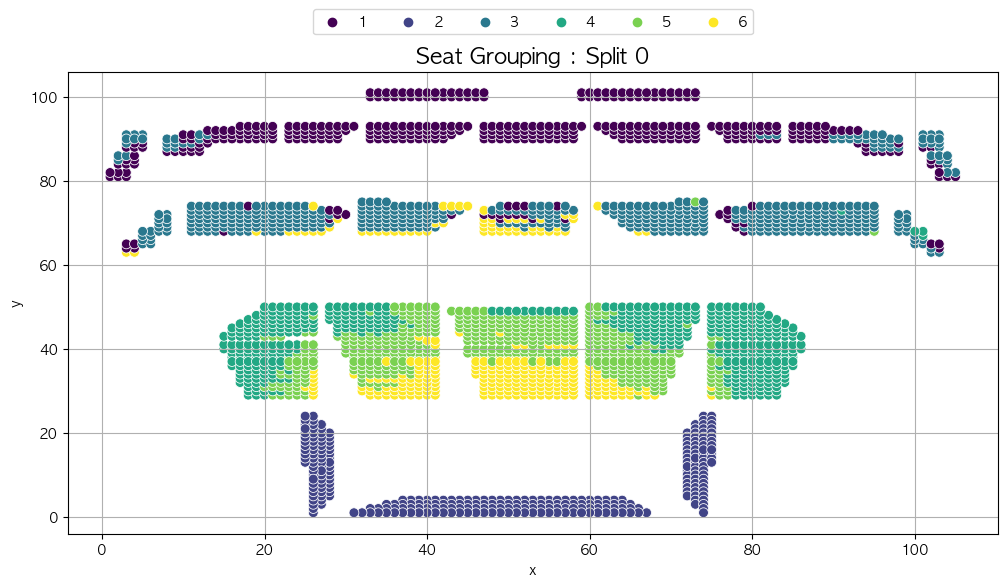

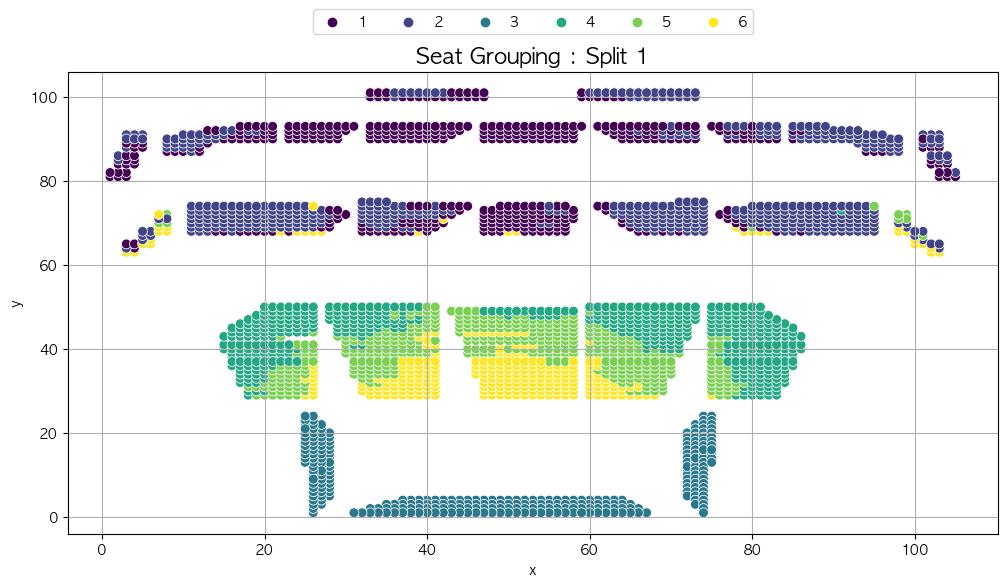

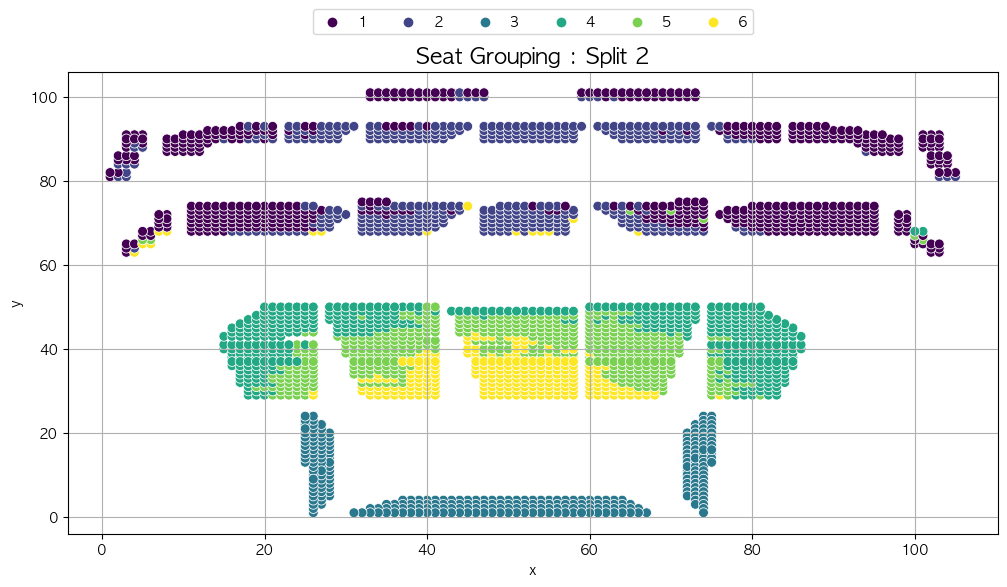

In [402]:
Visualize_SeatClustering()

## Visualize_Silhouette_K()

In [403]:
def Visualize_Silhouette_K(cluster_lists=[5,6,7,8,9,10], data_final_scaled=data_final_scaled):     
    ncols = len(cluster_lists)  # cluster cases
    nrows = 3  # split
    fig, axes = plt.subplots(figsize=(20,20), nrows=nrows, ncols=ncols)
    
    for s in range(0, 3):
        X_features = data_final_scaled[data_final_scaled['split']==s]
    
        for i, n_cluster in enumerate(cluster_lists):
            clusterer = KMeans(n_clusters=n_cluster, max_iter=500, n_init=10, random_state=42)
            cluster_labels = clusterer.fit_predict(X_features)
            
            sil_avg = silhouette_score(X_features, cluster_labels)
            sil_values = silhouette_samples(X_features, cluster_labels)    

            ax = axes[s,i]
        
            y_lower = 10
            ax.set_title(f'Split {s}\n Number of Cluster : {n_cluster} \nSilhouette Score : {round(sil_avg,3)}')
            ax.set_xlabel('The Silhouette Coefficient Values'); ax.set_ylabel('Cluster Label')
            ax.set_xlim([-0.1,1]); ax.set_ylim([0, len(X_features)+(n_cluster+1)*10])
            ax.set_yticks([]); ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
        
            for i in range(n_cluster):
                ith_cluster_sil_values = sil_values[cluster_labels==i]
                ith_cluster_sil_values.sort()
                
                size_cluster_i = ith_cluster_sil_values.shape[0]
                y_upper = y_lower + size_cluster_i
                
                color = cm.nipy_spectral(float(i)/n_cluster)
                ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                                 facecolor=color, edgecolor=color, alpha=0.7)
                ax.text(-0.05, y_lower+0.5*size_cluster_i, str(i))
                y_lower = y_upper + 10
            
            ax.axvline(x=sil_avg, color='red', linestyle='--')
    
    plt.tight_layout()
    plt.show()

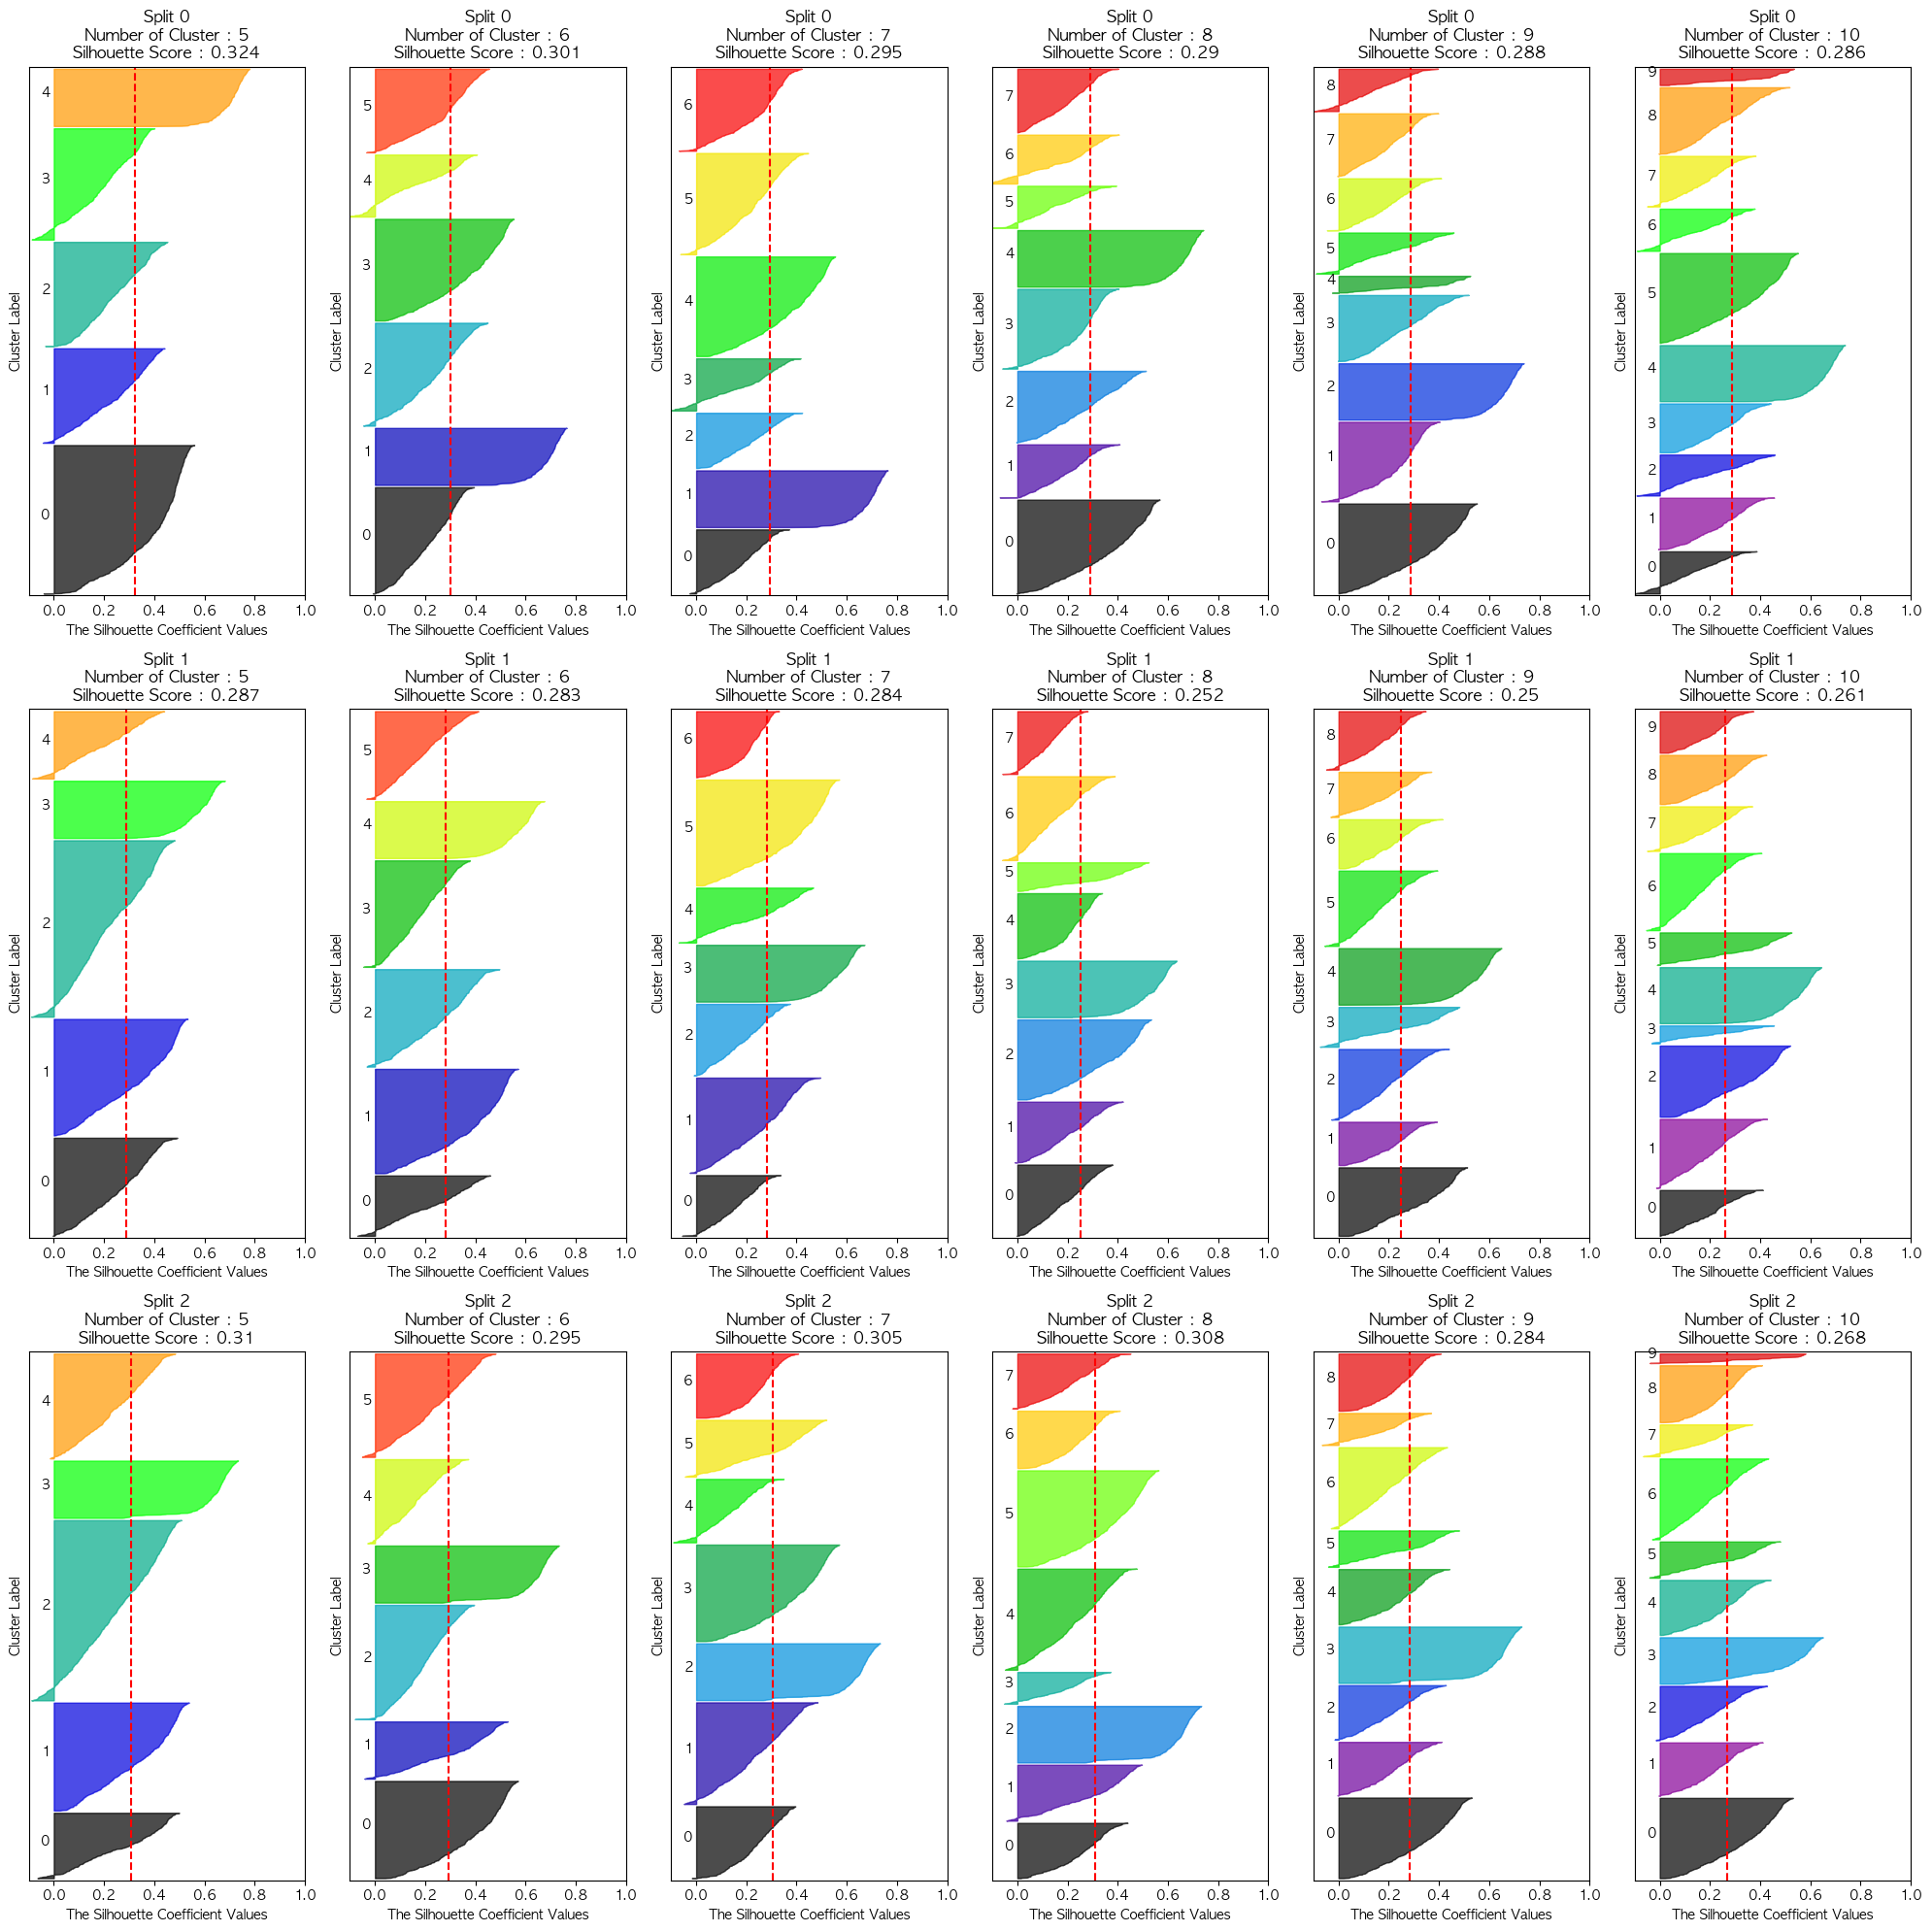

In [404]:
Visualize_Silhouette_K()

In [405]:
seat_group_df

split          seat  floor     x     y       dist  dist_f_rnk  book_cnt  \
0         0   1층 A블록10열 1      1  16.0  38.0  41.400483       400.0        85   
1         0  1층 A블록10열 10      1  25.0  38.0  34.655447       277.0       114   
2         0  1층 A블록10열 11      1  26.0  38.0  33.970576       263.0       128   
3         0   1층 A블록10열 2      1  17.0  38.0  40.607881       388.0        74   
4         0   1층 A블록10열 3      1  18.0  38.0  39.824616       378.0        83   
...     ...           ...    ...   ...   ...        ...         ...       ...   
7390      2   합창석 H블록4열 5      0  25.0  17.0  24.331050        92.0        64   
7391      2   합창석 H블록4열 6      0  25.0  18.0  24.515301        94.0        52   
7392      2   합창석 H블록4열 7      0  25.0  19.0  24.738634        96.0        57   
7393      2   합창석 H블록4열 8      0  25.0  20.0  25.000000        97.0        44   
7394      2   합창석 H블록4열 9      0  25.0  21.0  25.298221       101.0        49   

      sound_info   ttf_rnk_m  seat_rnk_pnt_w_m  free_0_wr_m  free_1_wr_m  \
0              2  241.435294          6.823529   329.091009   323.373904   
1              2  153.754386          8.315789   310.773026   297.510746   
2              2  161.148438          8.132812   306.717105   278.032895   
3              2  270.486486          7.770270   342.097588   333.312500   
4              2  245.313253          7.975904   338.271930   325.500000   
...          ...         ...               ...          ...          ...   
7390           0  180.142857          3.714286   194.250000   190.771739   
7391           0  197.000000          4.600000   198.423913   193.097826   
7392           0  165.857143          3.857143   198.423913   194.155797   
7393           0  189.200000          6.000000   199.684783   194.076087   
7394           0  220.666667          5.000000   199.836957   193.097826   

      percent_q75   cost_m  age_10_20  age_30_40_50  age_60_70_80  Cluster  
0            0.15  67483.0          2            17            10        4  
1            0.20  88034.0          3            21            15        5  
2            0.40  90489.0          6            25            18        5  
3            0.15  83196.0          5            15             7        4  
4            0.20  73426.0          3            11            10        4  
...           ...      ...        ...           ...           ...      ...  
7390         0.00  63226.0          4            13             7        3  
7391         0.00  57200.0          5             9             5        3  
7392         0.05  59464.0          5             9             8        3  
7393         0.20  70800.0          7            11             3        3  
7394         0.00  60370.0          4            10             6        3  

[7395 rows x 19 columns]

In [406]:
def Logit_model(df1):
    df1 = df1.drop(['seat','split'],axis=1)
    train, test = train_test_split(df1, test_size=0.3, random_state=42,stratify=df1['Cluster'])
    train_scaled = train.drop(['Cluster'],axis=1)
    train_target = train['Cluster']
    test_scaled = test.drop(['Cluster'],axis=1)
    test_target = test['Cluster']
    lr = LogisticRegression(C=20, max_iter=1000)
    lr.fit(train_scaled, train_target)
    print(lr.score(test_scaled, test_target))
    print(lr.coef_)


def Logit_vis(df1):

    df1 = df1.drop(['seat','split'],axis=1)
    train, test = train_test_split(df1, test_size=0.3, random_state=42,stratify=df1['Cluster'])
    train_scaled = train.drop(['Cluster'],axis=1)
    train_target = train['Cluster']
    test_scaled = test.drop(['Cluster'],axis=1)
    test_target = test['Cluster']
    lr = LogisticRegression(C=20, max_iter=1000)
    lr.fit(train_scaled, train_target)

    class_labels = list(train_target.unique()) # 클래스 레이블은 실제 데이터에 맞게 수정해야 합니다.

    # 클래스별 회귀 계수 플롯
    for class_label in class_labels:
        # 회귀 모델에서 학습한 회귀 계수
        coefficients = lr.coef_[class_label -1]

        # 데이터프레임의 컬럼 이름 가져오기 (Cluster 열 제외)
        feature_names = df1.columns.tolist()
        feature_names.remove('Cluster')  # 'Cluster' 열은 제외

        # 회귀 계수 플롯
        plt.figure(figsize=(10, 5))
        plt.barh(feature_names, coefficients, color='b')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.title(f'Logistic Regression Coefficients for Class {class_label}')
        plt.show()

        # 변수 중요도 플롯 (절댓값 기준)
        plt.figure(figsize=(12, 6))
        plt.barh(feature_names, abs(coefficients), color='g')
        plt.xlabel('Absolute Coefficient Value')
        plt.ylabel('Feature')
        plt.title(f'Feature Importance for Class {class_label} (Absolute Value of Coefficients)')
        plt.show()



In [407]:
seat_group_df_0 = seat_group_df[seat_group_df['split']==0].reset_index(drop=True)
seat_group_df_1 = seat_group_df[seat_group_df['split']==1].reset_index(drop=True)
seat_group_df_2 = seat_group_df[seat_group_df['split']==2].reset_index(drop=True) 

0.9297297297297298
[[ 2.81421578e-03  3.05387229e-02  6.94864222e-02  6.34716688e-02
  -4.13561914e-02  9.08812322e-02 -1.07744300e-03 -4.09711283e-02
  -5.47344035e-04  6.38676182e-02 -3.87583020e-02 -7.36173887e-05
  -1.49489001e-04  1.61271618e-02  3.41648207e-02  1.98506740e-02]
 [-2.64027073e-03  8.81820992e-03 -7.38791239e-02 -4.97845876e-02
  -9.08959955e-02 -6.08079364e-02 -4.44443450e-04  6.19342168e-02
  -3.97631499e-03  6.62725578e-02  4.52809022e-02 -1.22879586e-04
  -3.51734454e-04 -4.33936618e-03 -1.15643922e-02 -5.66239603e-03]
 [ 2.92485519e-03  3.29764818e-04  1.03574692e-01  9.37811252e-02
  -2.78409012e-04 -3.61319541e-02 -6.08131019e-04  1.18622661e-02
  -1.15543970e-03 -3.25299537e-02  1.89706066e-02  1.39848195e-04
   5.06651540e-05  5.38995682e-04 -1.54435171e-02 -1.29064759e-02]
 [-1.65398377e-03 -2.77220690e-03 -5.20456282e-02 -4.73816760e-02
   1.09732120e-01 -1.26979549e-01 -1.94733086e-05  9.14434037e-02
  -1.34478075e-03 -8.77825575e-02 -9.30134224e-03 -3.0

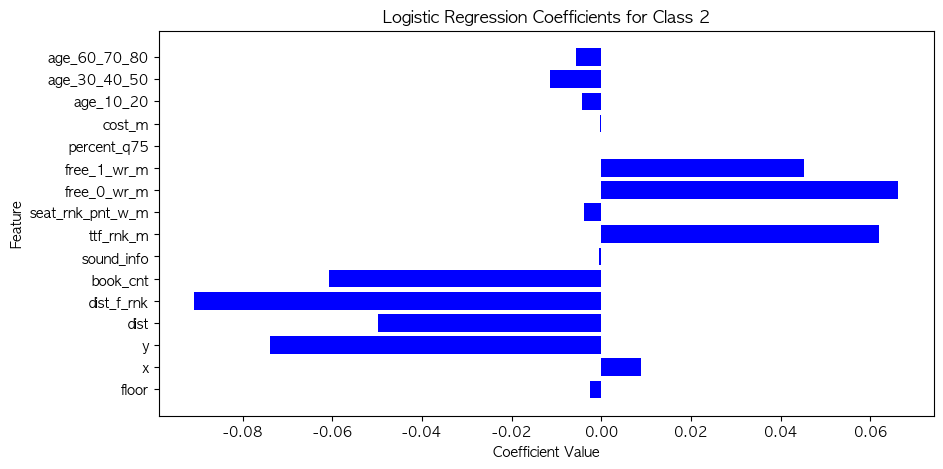

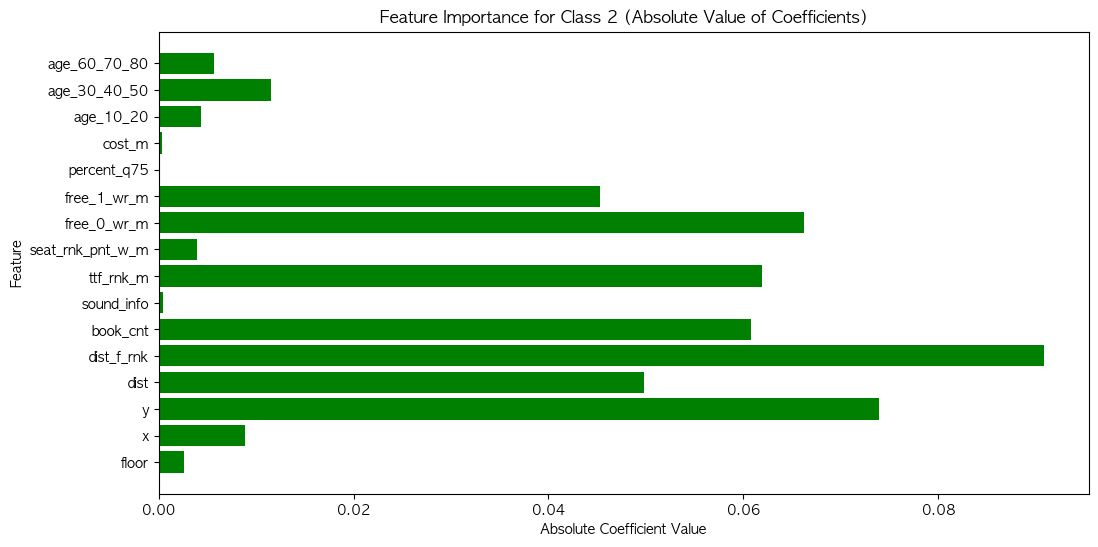

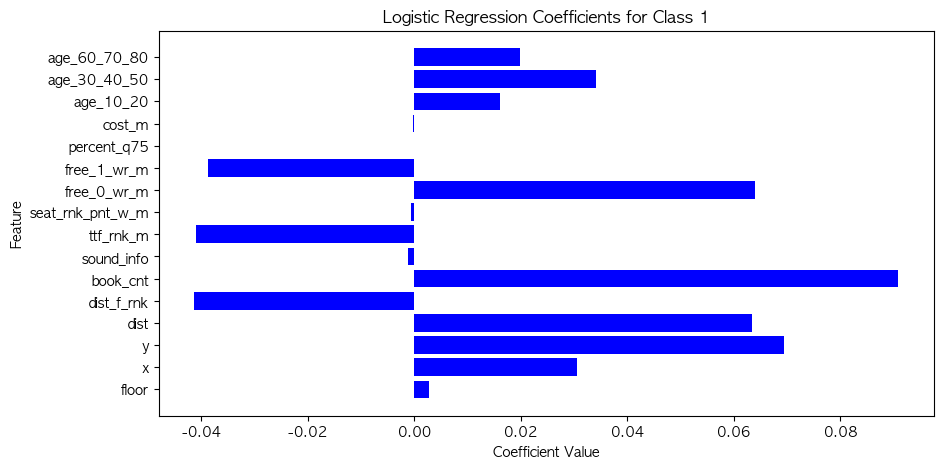

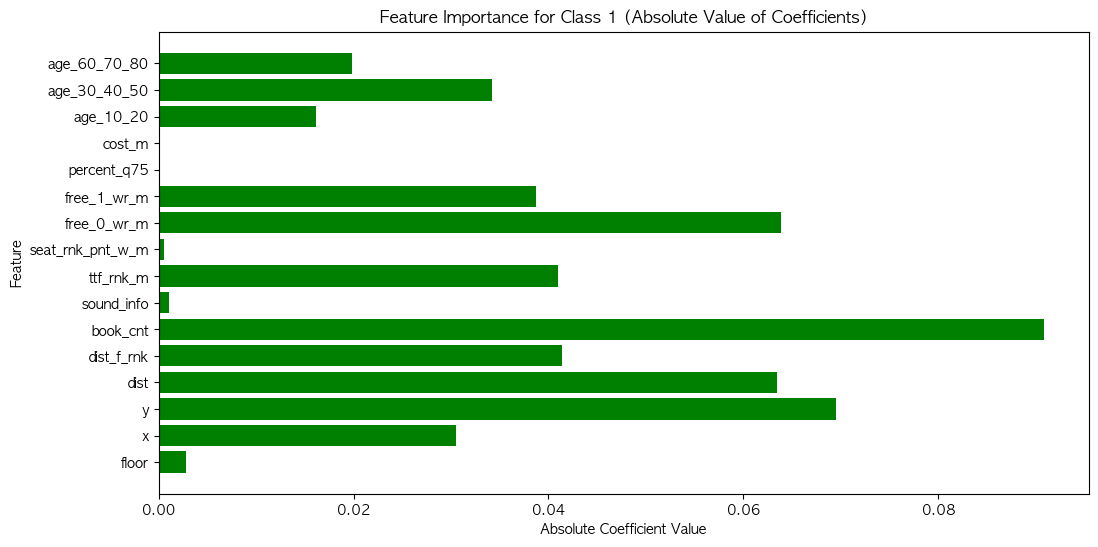

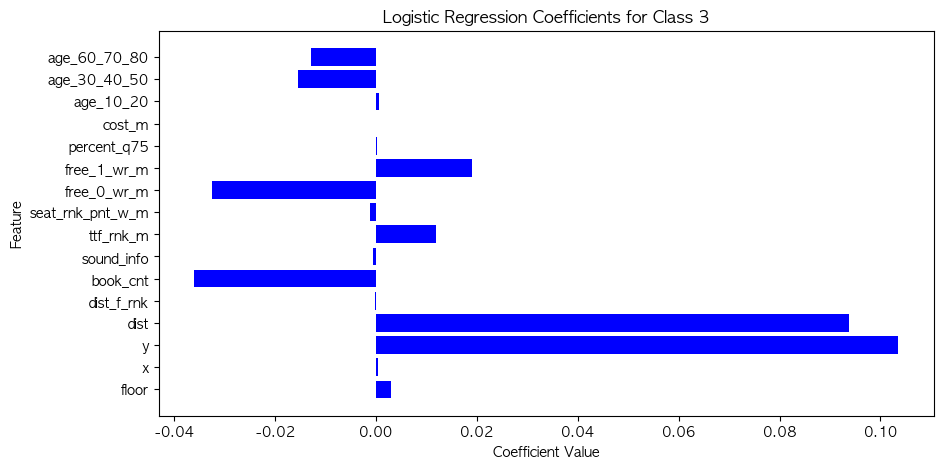

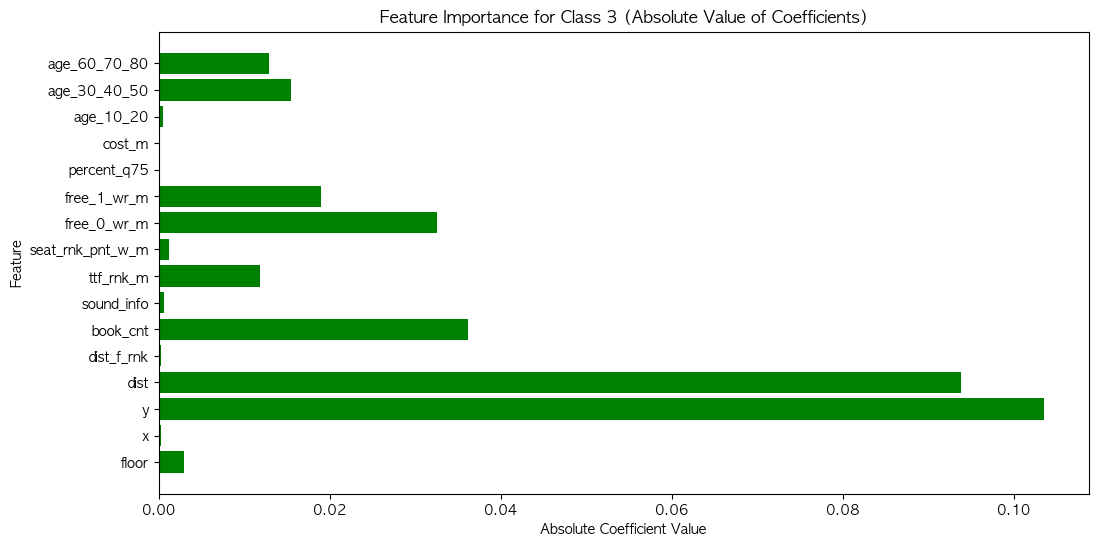

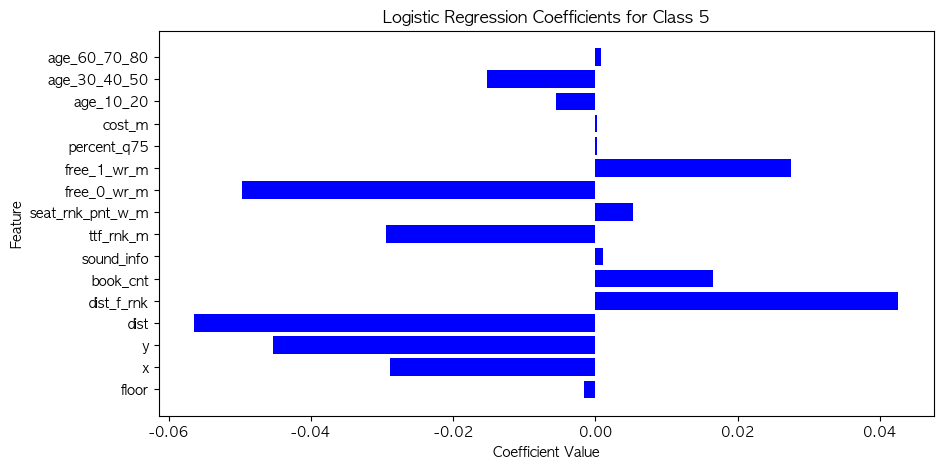

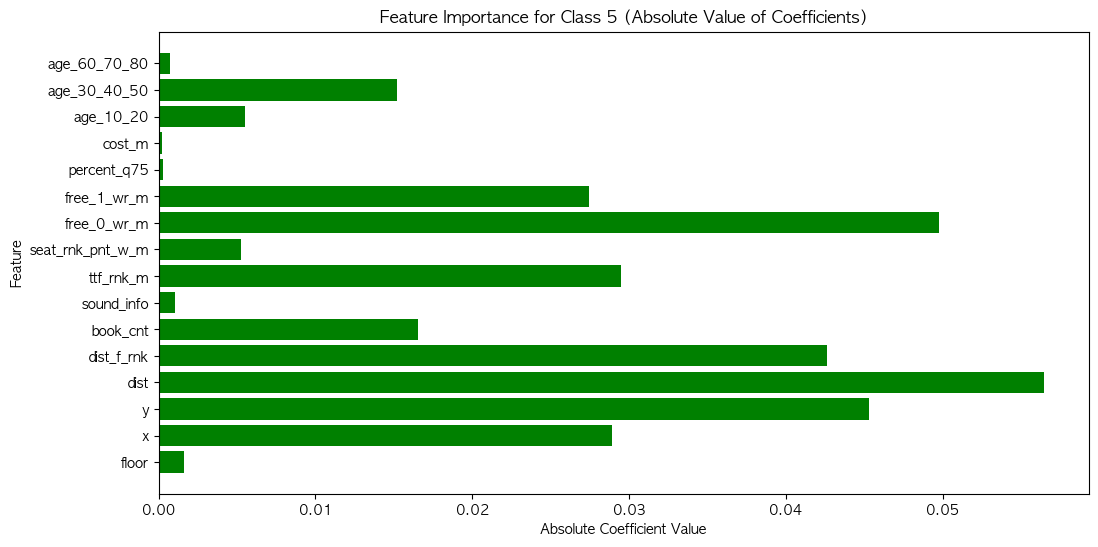

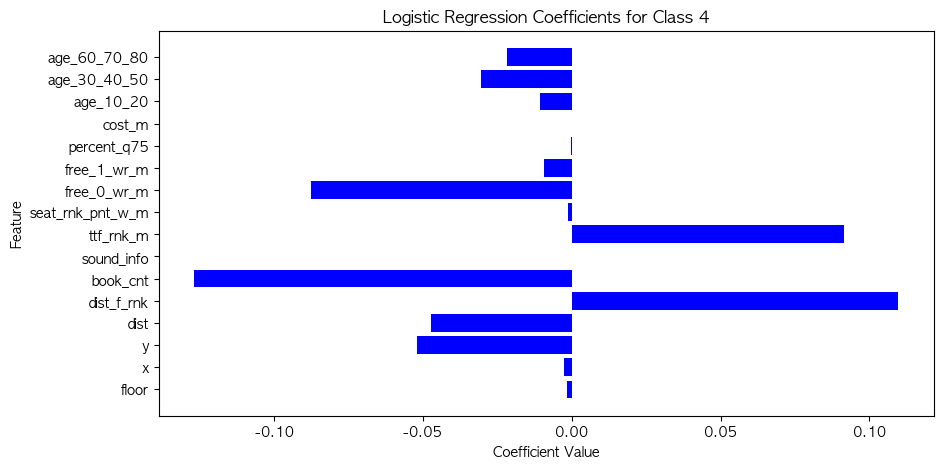

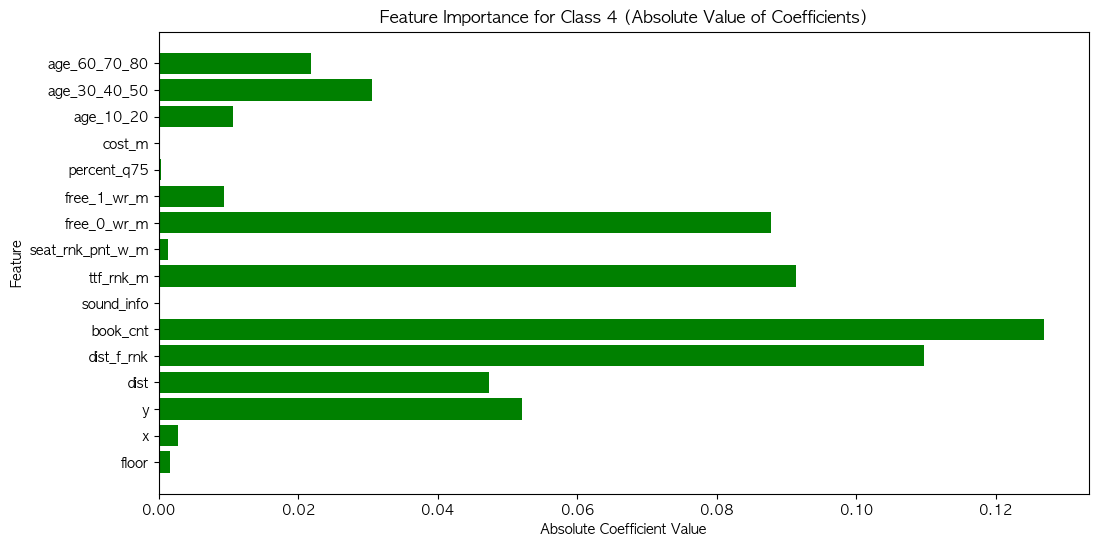

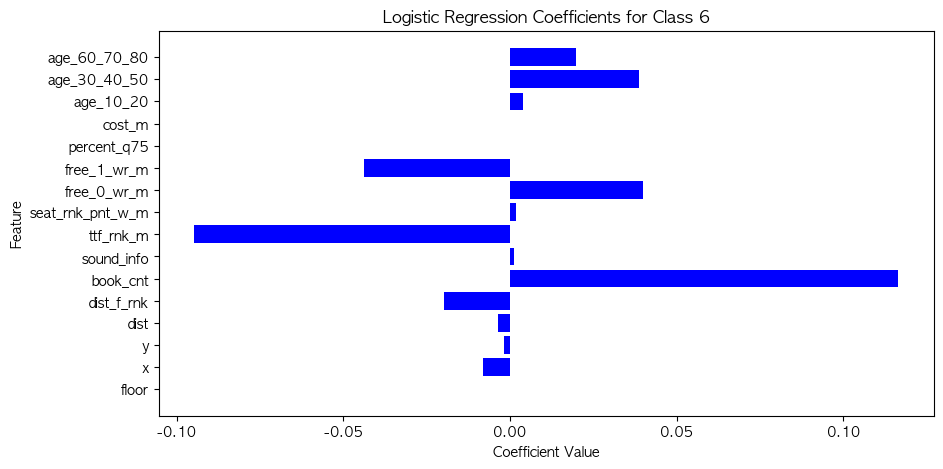

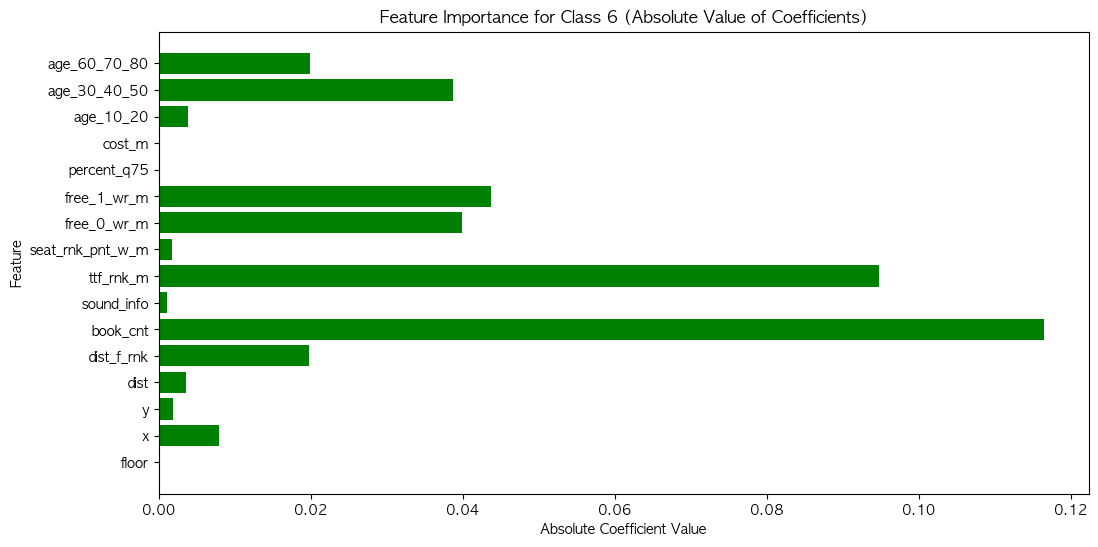

In [408]:
Logit_model(seat_group_df_0)
Logit_vis(seat_group_df_0)

0.9243243243243243
[[ 2.32251869e-03  5.22449866e-03  6.68879481e-02  5.25782543e-02
  -5.71435122e-02  6.16934150e-02 -1.89661392e-05 -3.16344856e-02
   8.33704334e-04  3.93349435e-02  1.46804711e-02  6.64233841e-05
  -1.69523425e-04  7.19038524e-03  1.92101946e-02  1.15477695e-02]
 [ 1.32305297e-03  4.50885882e-03  4.37944310e-02  3.78252722e-02
  -1.35548574e-02 -1.69728866e-02 -1.23027811e-04  6.40955021e-02
  -2.28959569e-04 -1.75179570e-02  3.22024914e-02 -2.73863285e-07
  -1.26906236e-04  1.37006113e-03 -6.79519262e-03 -4.38690522e-03]
 [-1.76766682e-03  9.38584259e-03 -5.04124118e-02 -2.84050004e-02
  -6.75817913e-02 -3.98100751e-02 -4.24597206e-04  1.81308008e-02
  -2.61062882e-03  8.79333355e-02  3.47087052e-02 -2.57080456e-05
  -3.18868593e-04 -1.70259568e-03 -5.46913778e-03 -3.92789513e-03]
 [-1.14174484e-03 -1.27166204e-02 -3.05995164e-02 -3.29696857e-02
   8.37344549e-02 -5.27625845e-02  3.50469461e-05  3.01754089e-02
  -1.26319944e-04 -8.52996245e-02  1.27088629e-03 -7.6

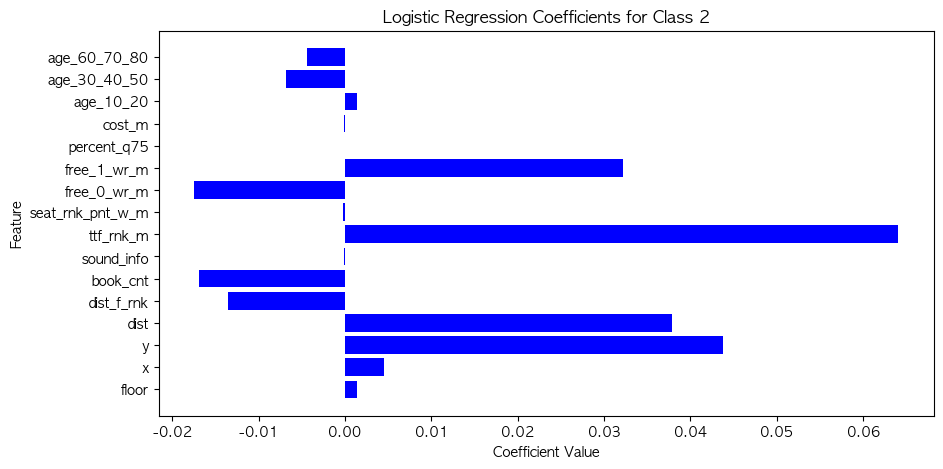

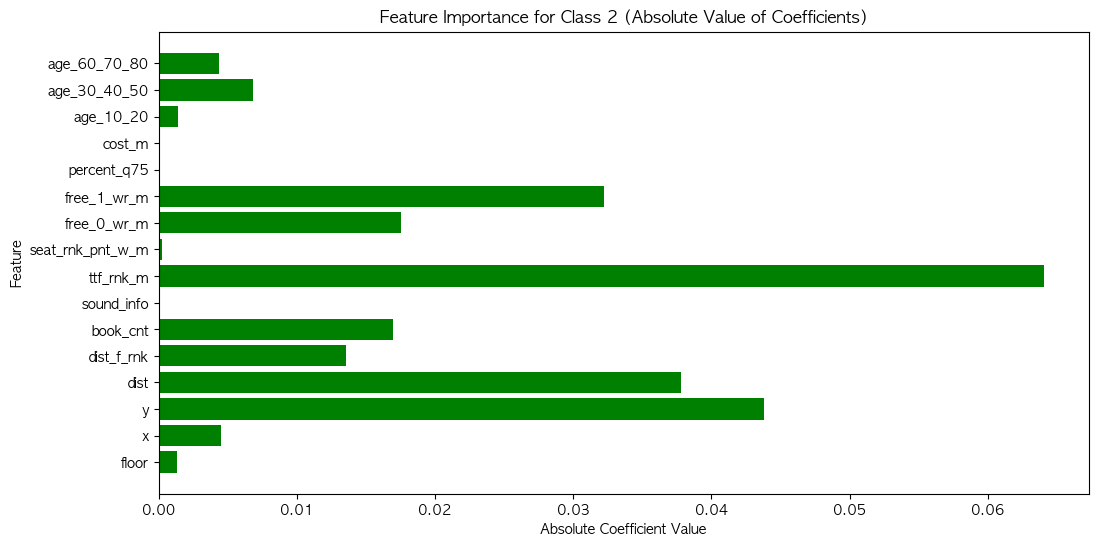

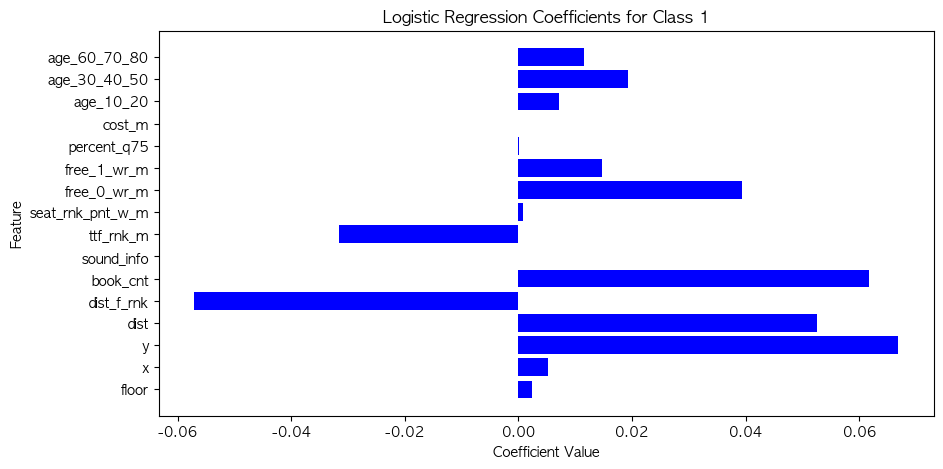

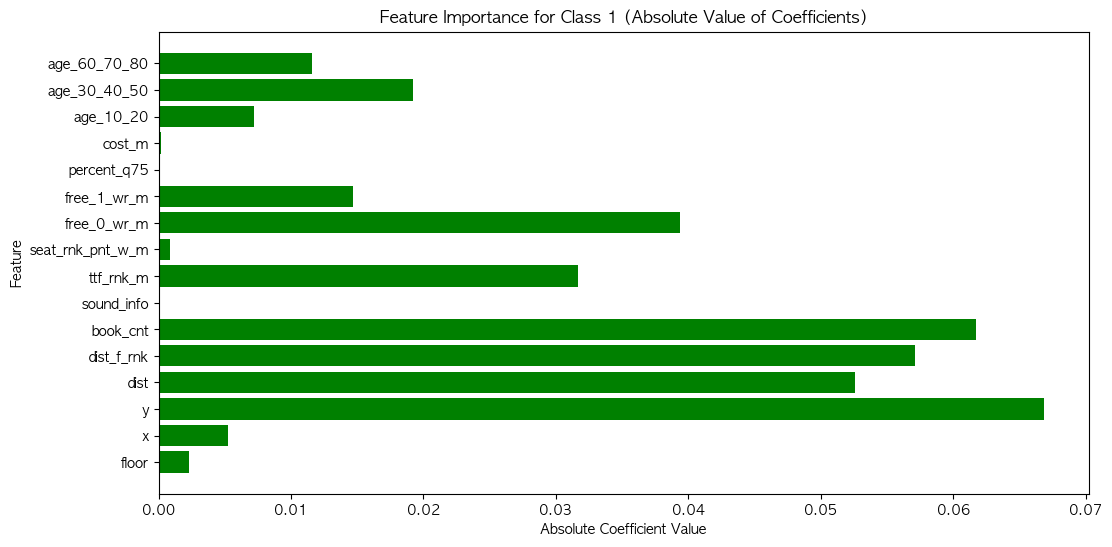

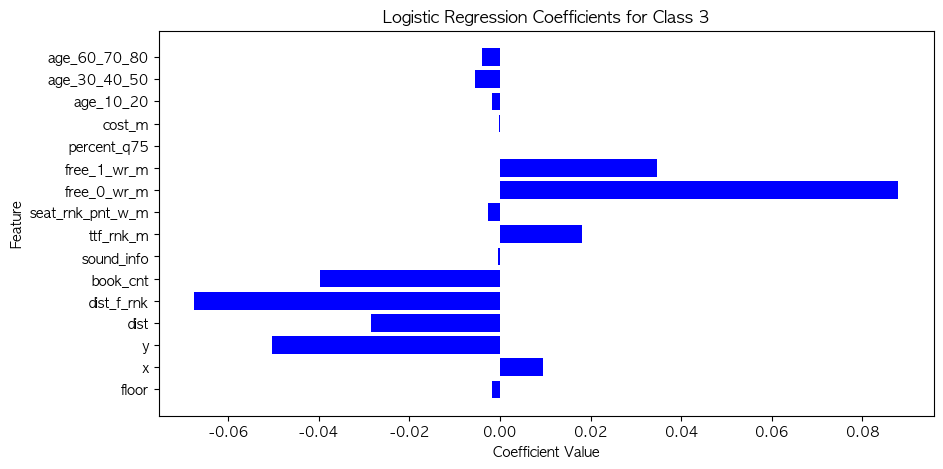

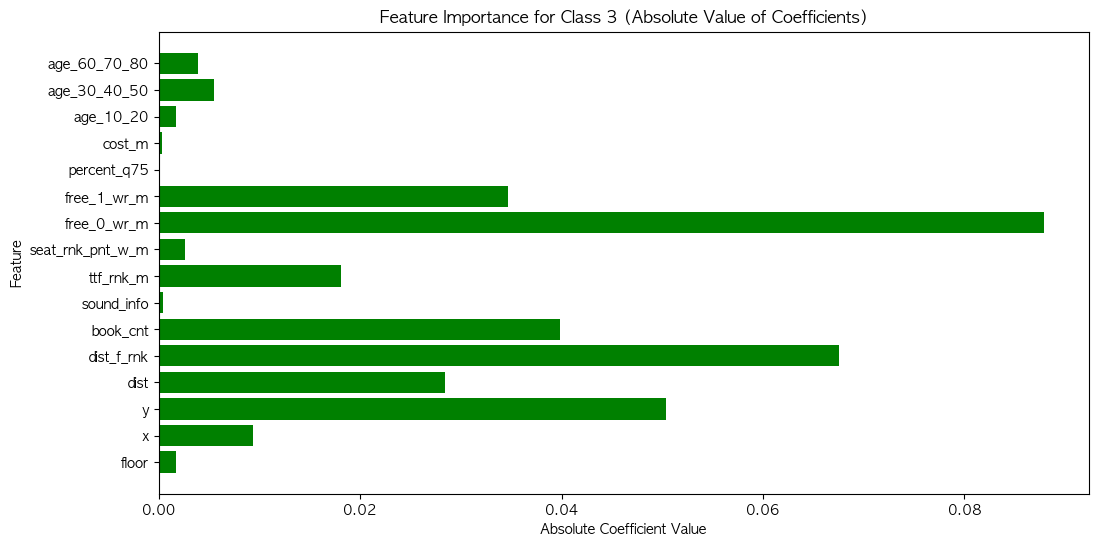

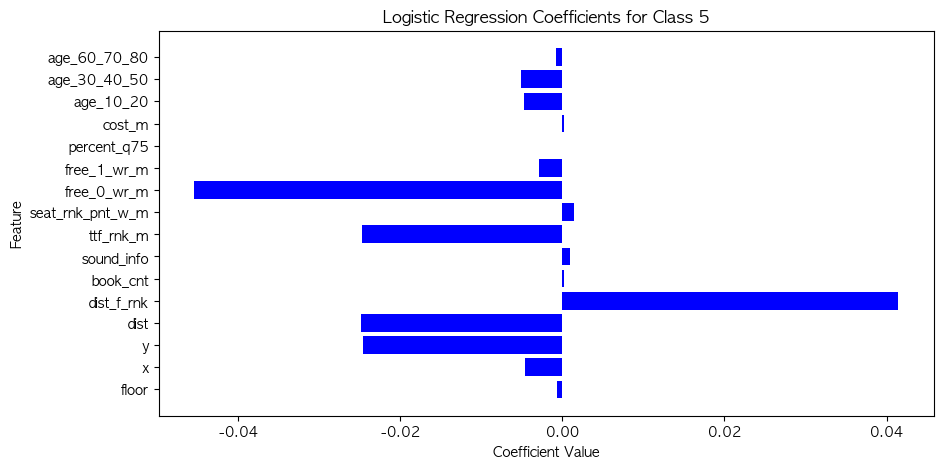

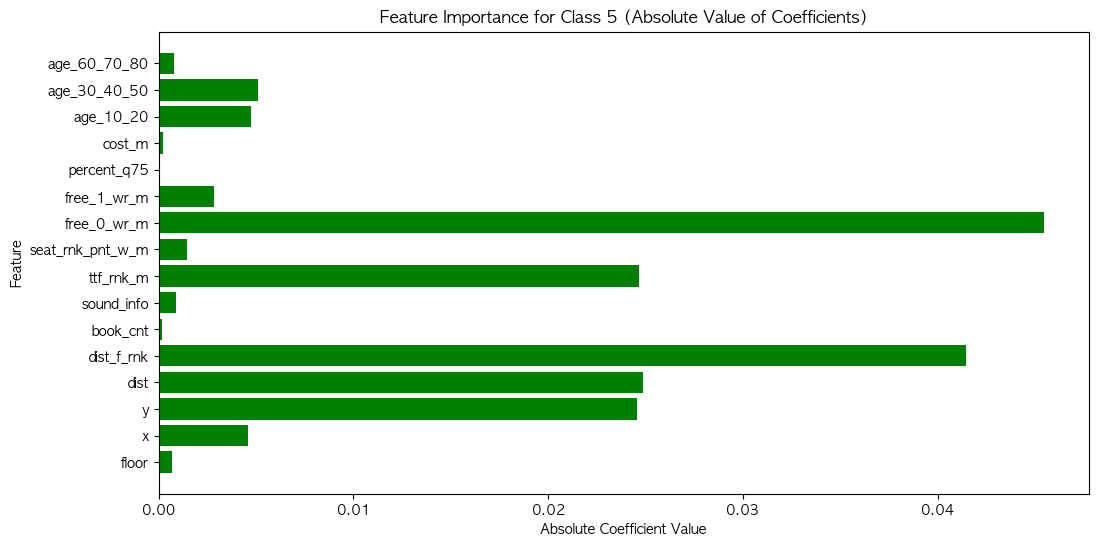

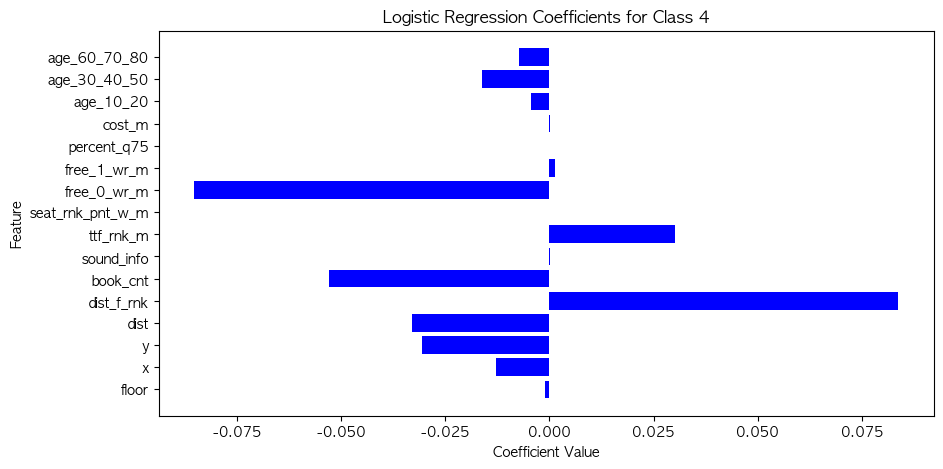

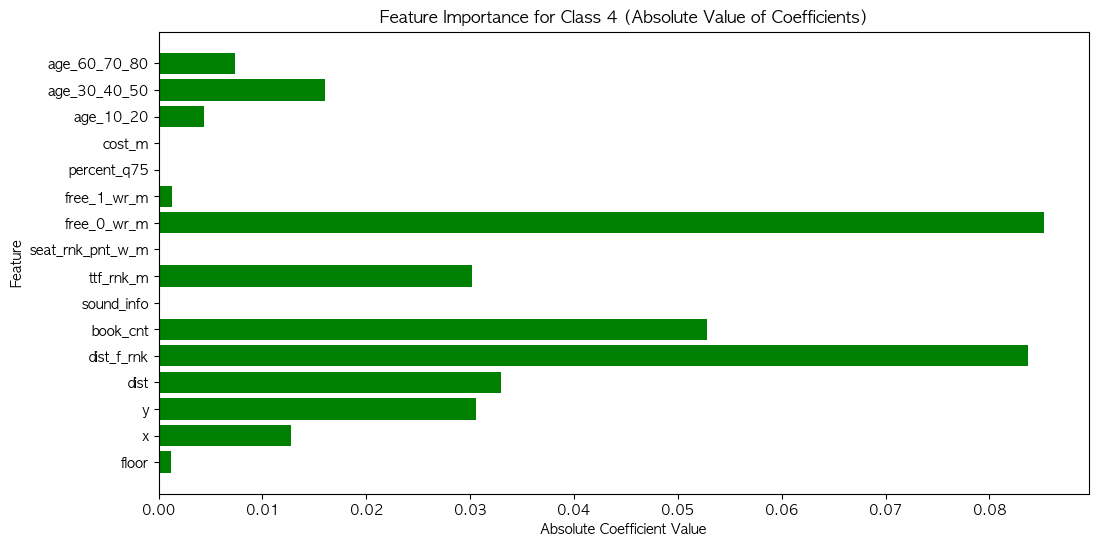

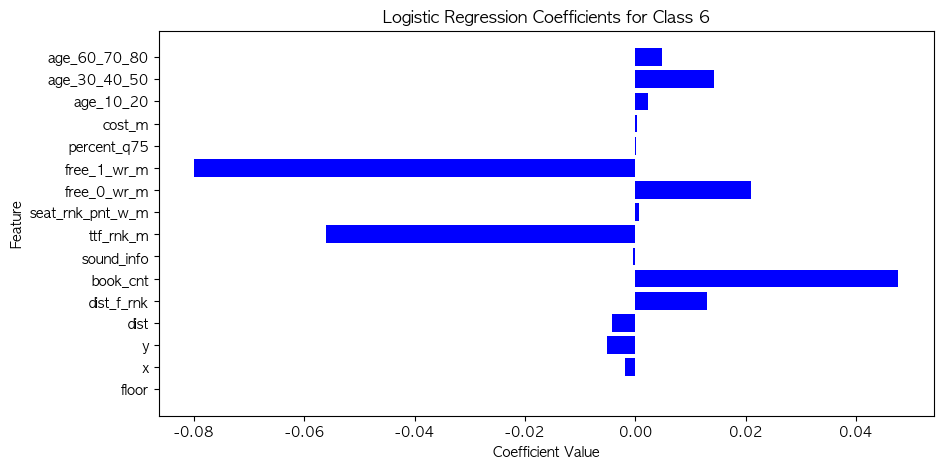

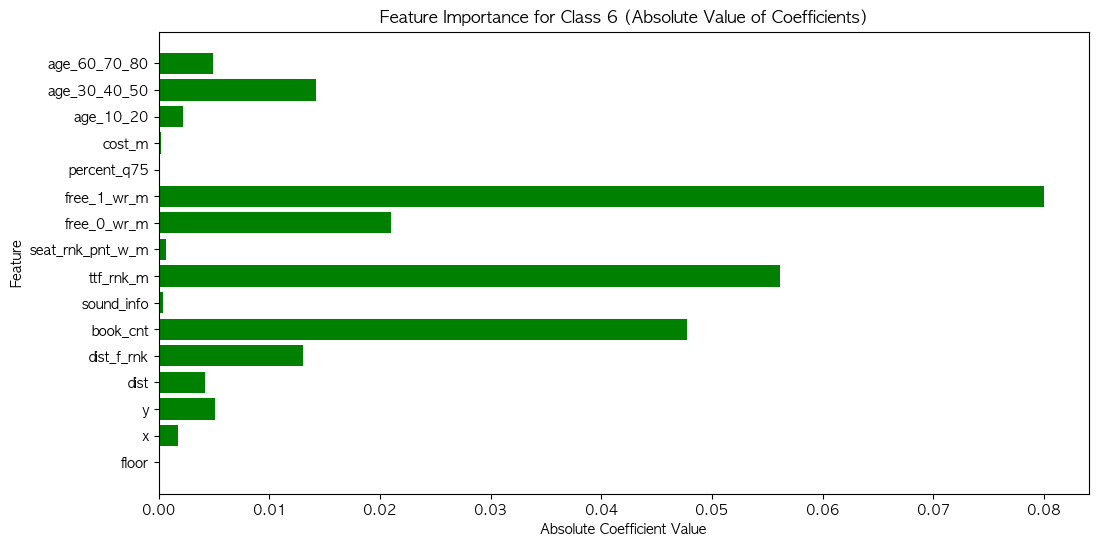

In [409]:
Logit_model(seat_group_df_1)
Logit_vis(seat_group_df_1)

0.9148648648648648
[[ 1.73230139e-03  1.10723738e-02  5.38440715e-02  5.51190011e-02
   1.15438361e-02 -1.69860286e-02 -6.86895905e-04  2.43691505e-02
  -1.34439926e-04  3.47688989e-02  1.27112707e-02  9.67230654e-05
  -1.69450275e-04  4.46987106e-03 -8.12065678e-04 -1.03423073e-02]
 [ 2.67556418e-03  1.52885621e-02  8.36892677e-02  6.64180931e-02
  -4.44109655e-02  5.39940503e-02  2.80925750e-04 -1.15644969e-02
   6.76203615e-04 -2.81490244e-04  2.53898470e-02  5.13614140e-05
  -9.88957800e-05  5.38852093e-03  1.23635484e-02  1.67736325e-02]
 [-1.67059822e-03  1.01264473e-02 -4.80935577e-02 -2.77899760e-02
  -6.50076485e-02 -3.08347286e-02 -4.42019286e-04  6.03198024e-02
  -2.43110915e-03  6.26209384e-02  5.60201065e-02 -2.38278725e-04
  -1.74532273e-04 -1.29337654e-03 -3.33875734e-03 -3.33566328e-03]
 [-1.51979148e-03 -2.80963348e-02 -4.46416010e-02 -4.53228504e-02
   7.68918119e-02 -7.24427427e-02  1.82479161e-04  2.17925592e-02
  -1.56440418e-03 -3.98358988e-02 -3.76195005e-02 -1.1

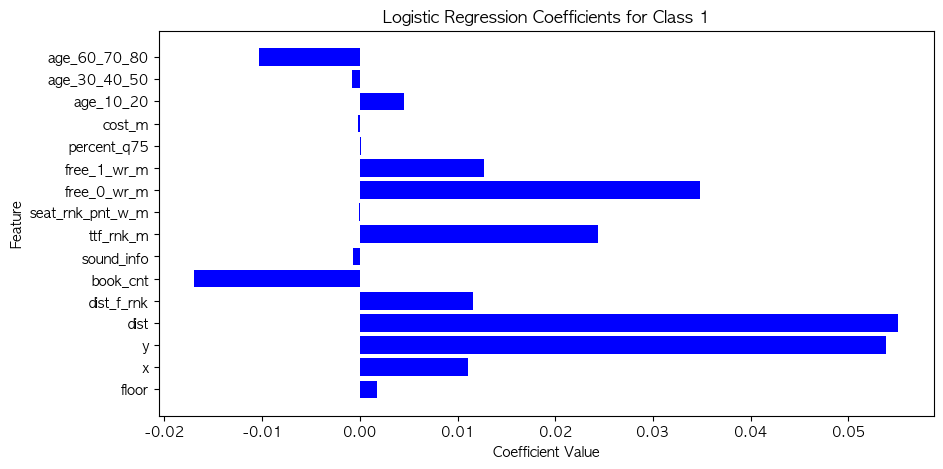

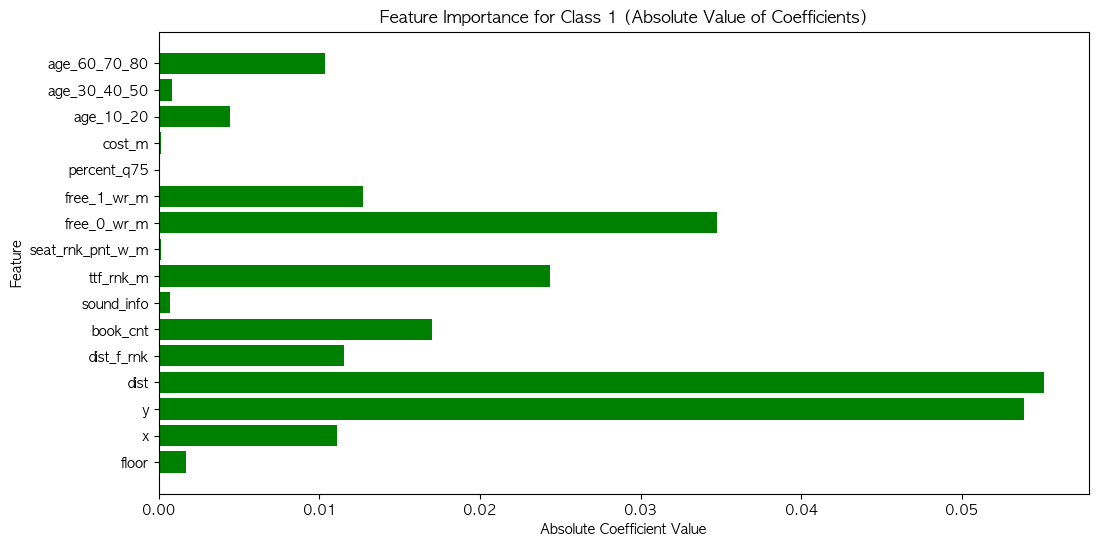

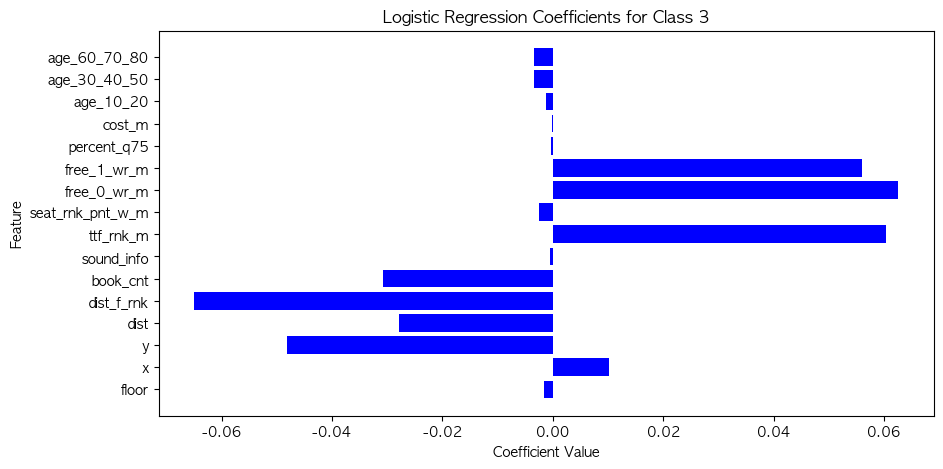

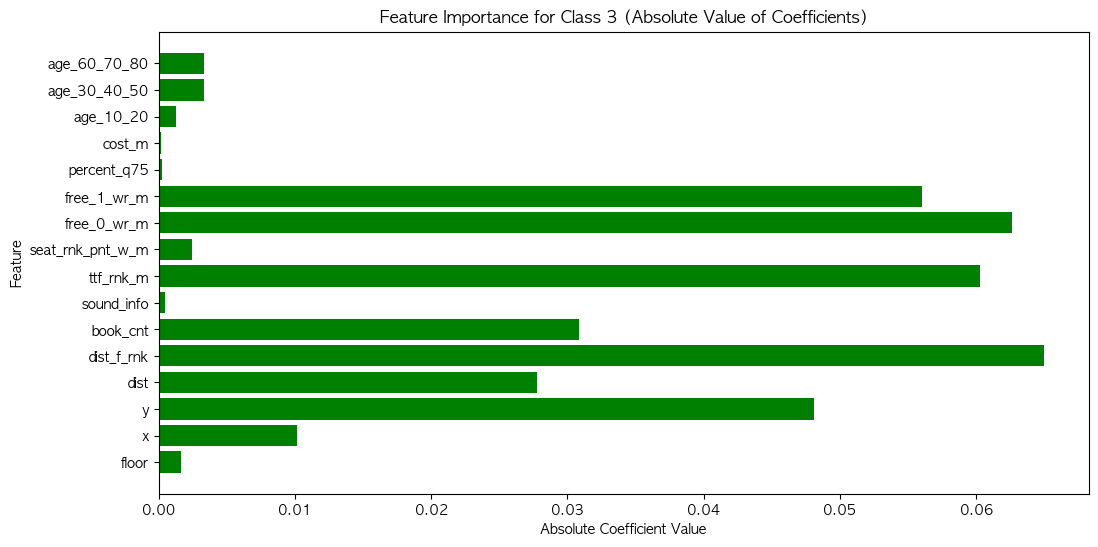

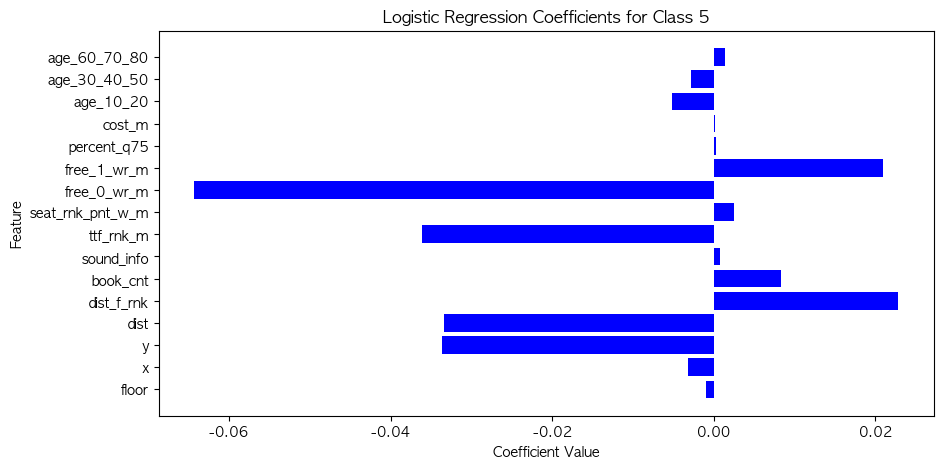

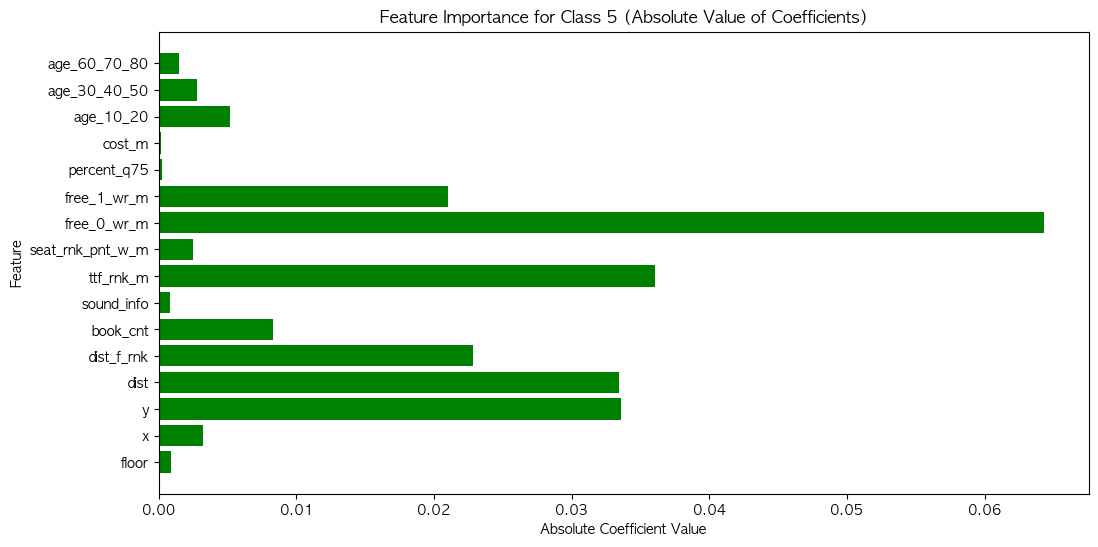

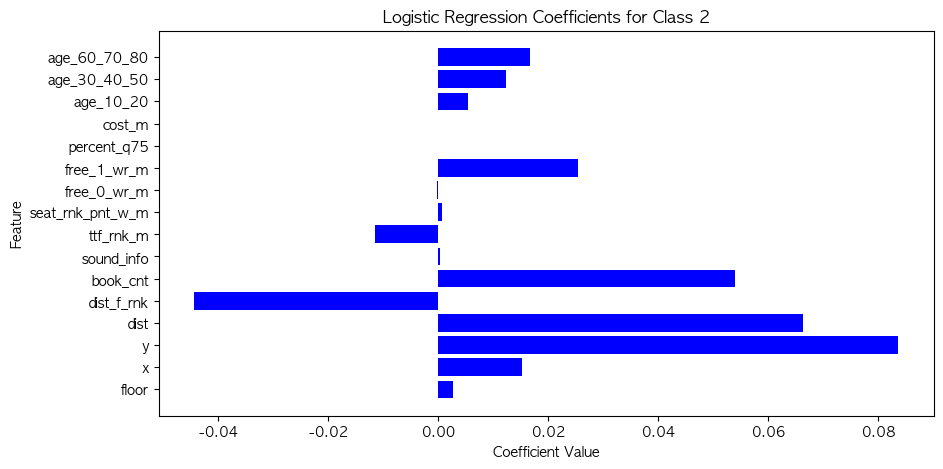

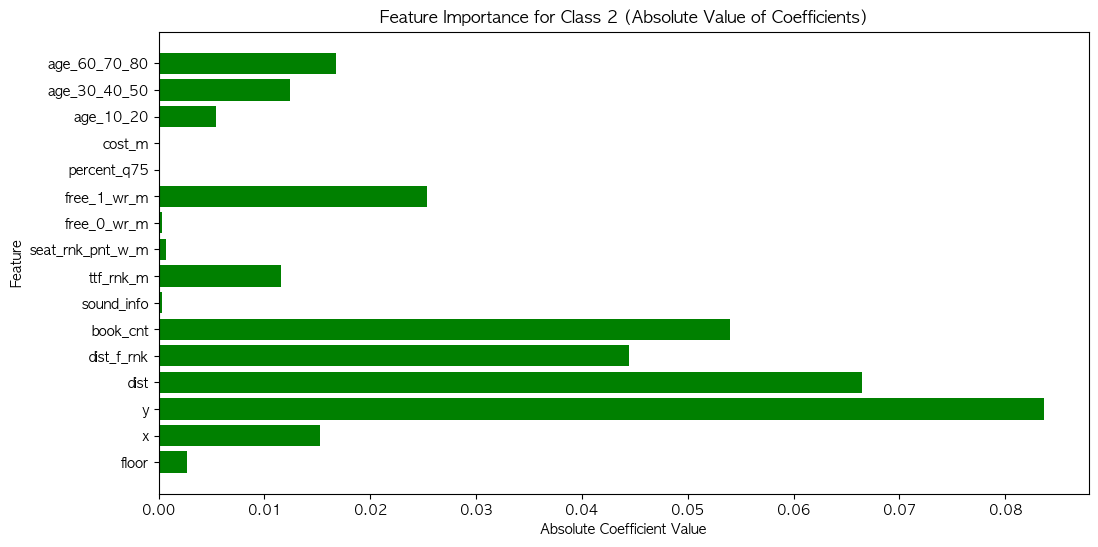

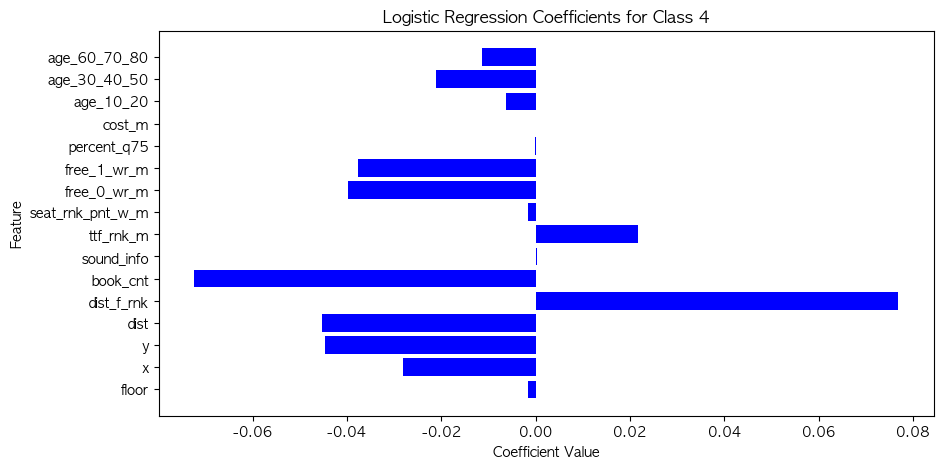

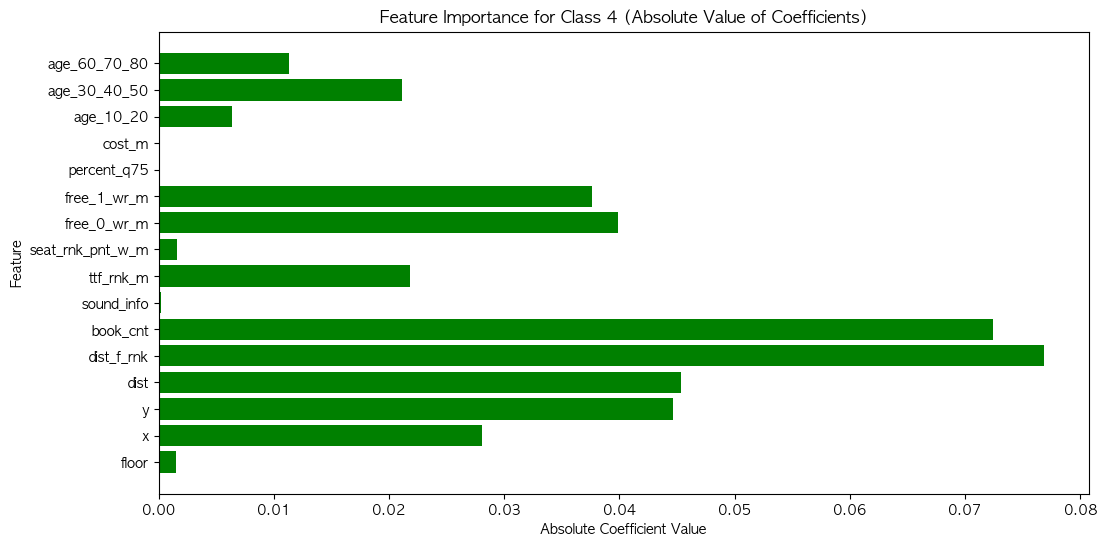

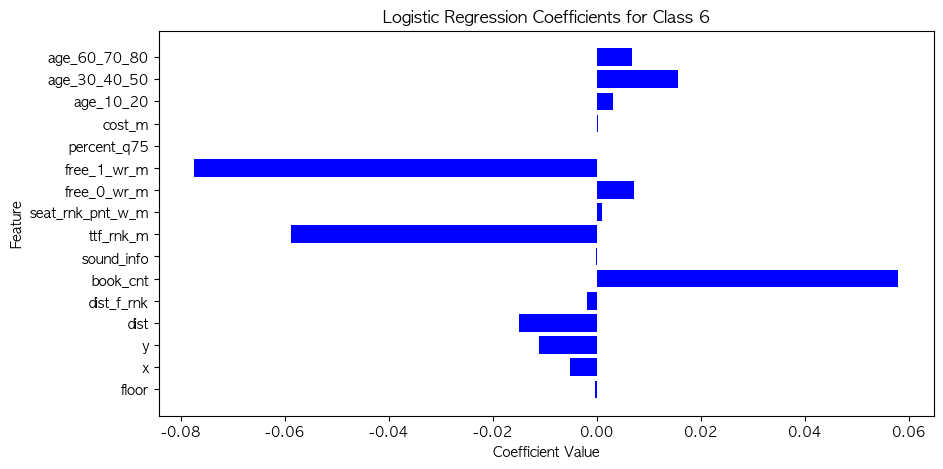

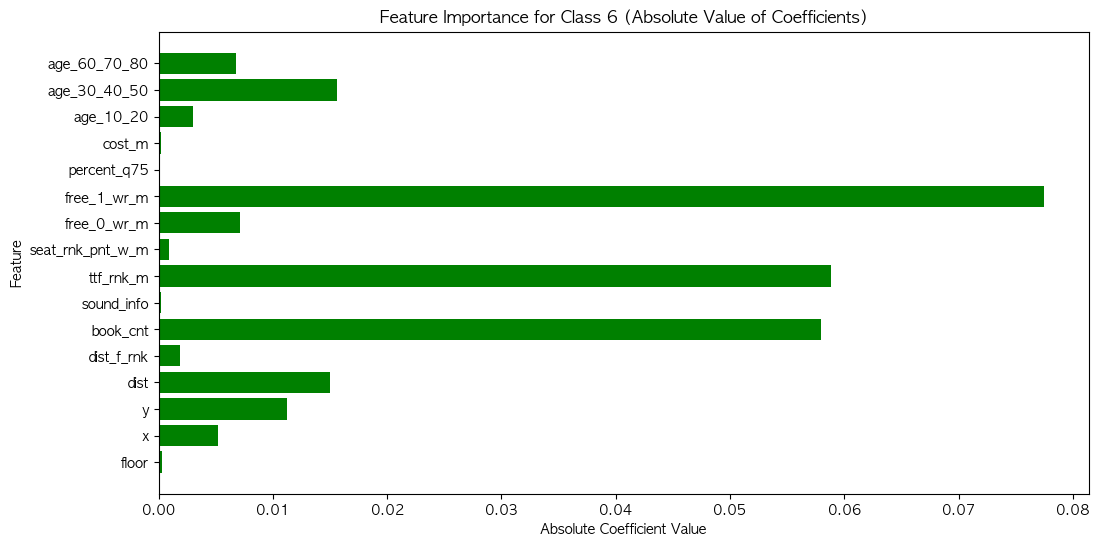

In [410]:
Logit_model(seat_group_df_2)
Logit_vis(seat_group_df_2)

In [411]:
seat_group_df.columns

Index(['split', 'seat', 'floor', 'x', 'y', 'dist', 'dist_f_rnk', 'book_cnt',
       'sound_info', 'ttf_rnk_m', 'seat_rnk_pnt_w_m', 'free_0_wr_m',
       'free_1_wr_m', 'percent_q75', 'cost_m', 'age_10_20', 'age_30_40_50',
       'age_60_70_80', 'Cluster'],
      dtype='object')

# 가격 선정 모델

In [412]:
# Linear Regressor

import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

def linear_regression_model(X, y):
    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X['Cluster'], test_size=0.2, random_state=42)
    
    # 선형 회귀 모델 학습
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    
    # 예측
    y_pred = linear_model.predict(X_test)
    
    # 회귀 계수
    regression_coefficients = linear_model.coef_
    
    # 회귀 계수의 표준 오차 계산
    X_train_with_const = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train_with_const).fit()
    se = np.sqrt(np.diag(model.cov_params()))
    
    # 95% 신뢰 구간 계산
    conf_int1 = [reg_coef - 1.96 * se_coef for reg_coef, se_coef in zip(regression_coefficients, se)]
    conf_int2 = [reg_coef + 1.96 * se_coef for reg_coef, se_coef in zip(regression_coefficients, se)]
    
    # 차이 계산 및 평균 계산
    diff_between_intervals = [upper_1 - lower_2 for upper_1, lower_2 in zip(conf_int2, conf_int1)]
    mean_diff_between_intervals = sum(diff_between_intervals) / len(diff_between_intervals)

    # 성능 지표 계산
    mse_value = mean_squared_error(y_test, y_pred)
    rmse_value = mean_squared_error(y_test, y_pred, squared=False)
    mae_value = mean_absolute_error(y_test, y_pred)
    r2_value = r2_score(y_test, y_pred)
    
    # 회귀 계수 시각화
    plt.figure(figsize=(12, 8))
    sns.barplot(x=regression_coefficients, y=X.columns, palette="viridis")
    plt.title("Regression Coefficients from Linear Regression", fontsize=15)
    plt.xlabel("Coefficient Value", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.show()

    print( {
        "regression_coefficients": regression_coefficients,
        "mean_diff_between_intervals": mean_diff_between_intervals,
        "mse_value": mse_value,
        "rmse_value": rmse_value,
        "mae_value": mae_value,
        "r2_value": r2_value
    })

    return y_pred


def linear_regression_model_Fianl(X, y):
    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X['Cluster'], test_size=0.2, random_state=42)
    
    # 선형 회귀 모델 학습
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    
    # 회귀 계수
    regression_coefficients = linear_model.coef_


    y_pred_final = linear_model.predict(X)

    return y_pred_final,regression_coefficients



In [413]:
seat_scaled_df_0 = seat_group_df_0

data_cluster = seat_scaled_df_0[['age_10_20', 'age_60_70_80','dist_f_rnk','ttf_rnk_m','free_0_wr_m','free_1_wr_m','floor','book_cnt']]
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(data_cluster)
data_scaled = scaler.fit_transform(data_cluster)
seat_scaled_df_0 = pd.concat([pd.DataFrame(data_scaled, columns=['age_10_20', 'age_60_70_80','dist_f_rnk','ttf_rnk_m','free_0_wr_m','free_1_wr_m','floor','book_cnt']),seat_scaled_df_0[['x','y','seat','percent_q75','Cluster']]],axis=1)

In [414]:
seat_scaled_df_1 = seat_group_df_1

data_cluster = seat_scaled_df_1[['age_10_20', 'age_60_70_80','dist_f_rnk','ttf_rnk_m','free_1_wr_m','free_1_wr_m','floor','book_cnt']]
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(data_cluster)
data_scaled = scaler.fit_transform(data_cluster)
seat_scaled_df_1 = pd.concat([pd.DataFrame(data_scaled, columns=['age_10_20', 'age_60_70_80','dist_f_rnk','ttf_rnk_m','free_1_wr_m','free_1_wr_m','floor','book_cnt']),seat_scaled_df_1[['x','y','seat','percent_q75','Cluster']]],axis=1)

In [415]:
seat_scaled_df_2 = seat_group_df_2

data_cluster = seat_scaled_df_2[['age_10_20', 'age_60_70_80','dist_f_rnk','ttf_rnk_m','free_1_wr_m','free_1_wr_m','floor','book_cnt']]
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(data_cluster)
data_scaled = scaler.fit_transform(data_cluster)
seat_scaled_df_2 = pd.concat([pd.DataFrame(data_scaled, columns=['age_10_20', 'age_60_70_80','dist_f_rnk','ttf_rnk_m','free_1_wr_m','free_1_wr_m','floor','book_cnt']),seat_scaled_df_2[['x','y','seat','percent_q75','Cluster']]],axis=1)

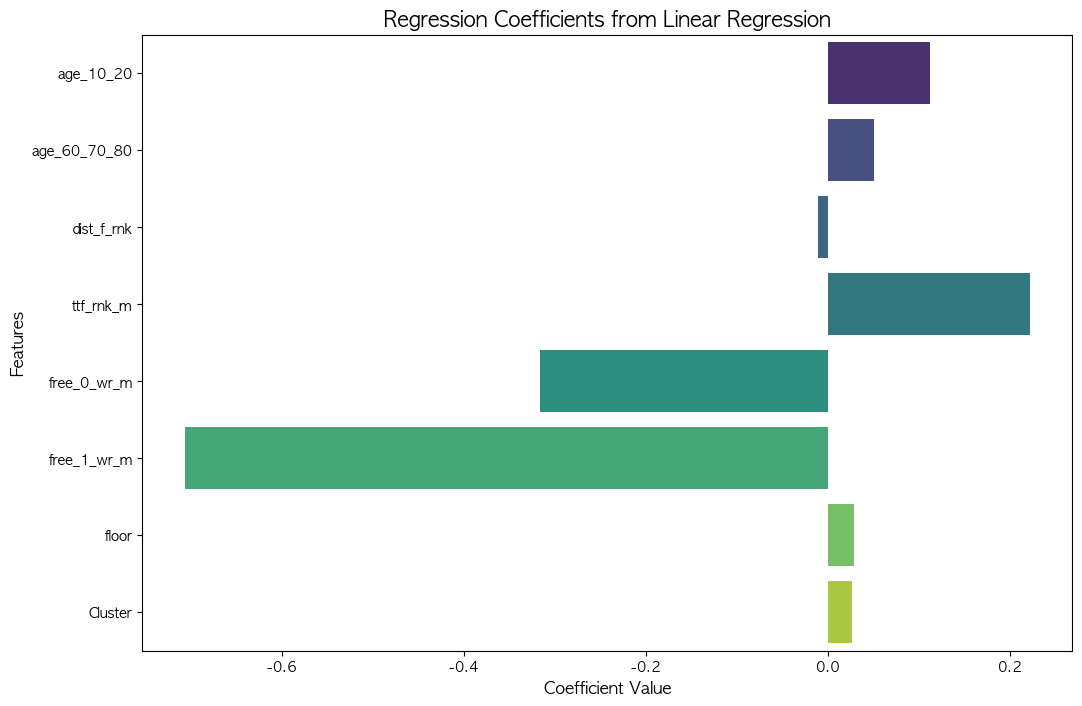

{'regression_coefficients': array([ 0.11135487,  0.05022682, -0.01159376,  0.22183566, -0.3162093 ,
       -0.70693464,  0.028491  ,  0.02569447]), 'mean_diff_between_intervals': 0.04128741514627529, 'mse_value': 0.0020821908087635815, 'rmse_value': 0.04563102901276259, 'mae_value': 0.03536788681663532, 'r2_value': 0.9004170139219645}


In [416]:
X = seat_scaled_df_0.drop(columns=['seat','x','y','percent_q75','book_cnt'])
y = seat_scaled_df_0['book_cnt']

y_pred_b_0 = linear_regression_model(X,y)

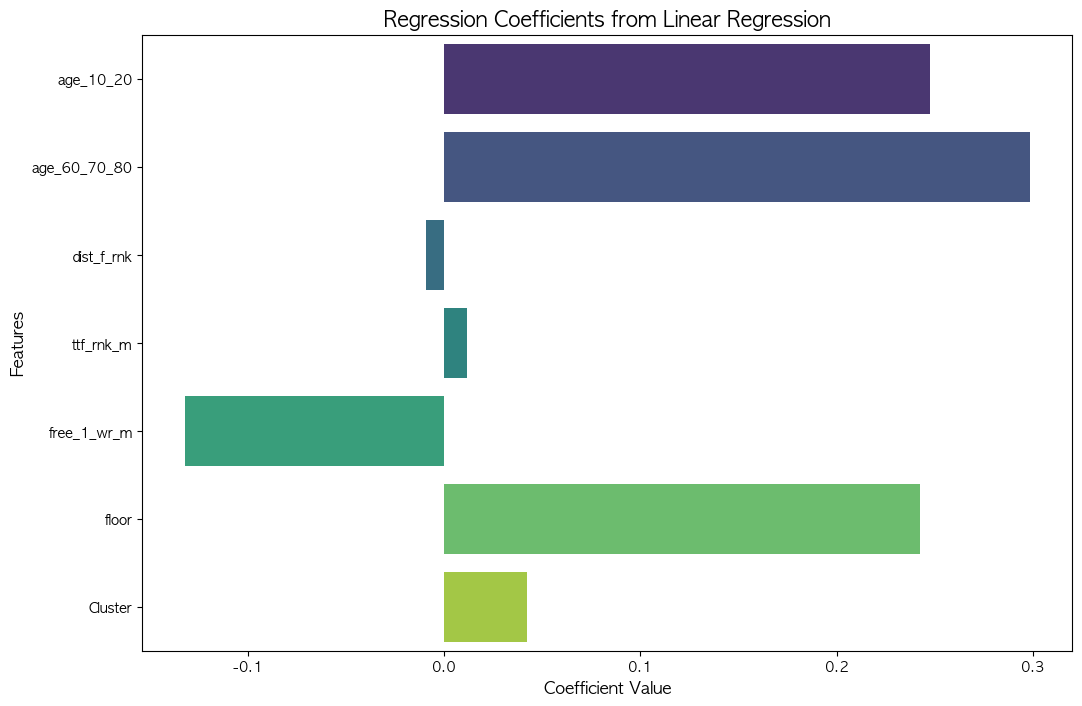

{'regression_coefficients': array([ 0.24771292,  0.29864156, -0.00931707,  0.01189197, -0.13216911,
       -0.13216911,  0.24264985,  0.04206938]), 'mean_diff_between_intervals': 0.047909786202112295, 'mse_value': 0.005822469990425574, 'rmse_value': 0.07630511116842419, 'mae_value': 0.05761092396183433, 'r2_value': 0.7624328078262695}


In [417]:
X = seat_scaled_df_1.drop(columns=['seat','x','y','percent_q75','book_cnt'])
y = seat_scaled_df_1['book_cnt']

y_pred_b_1 = linear_regression_model(X,y)

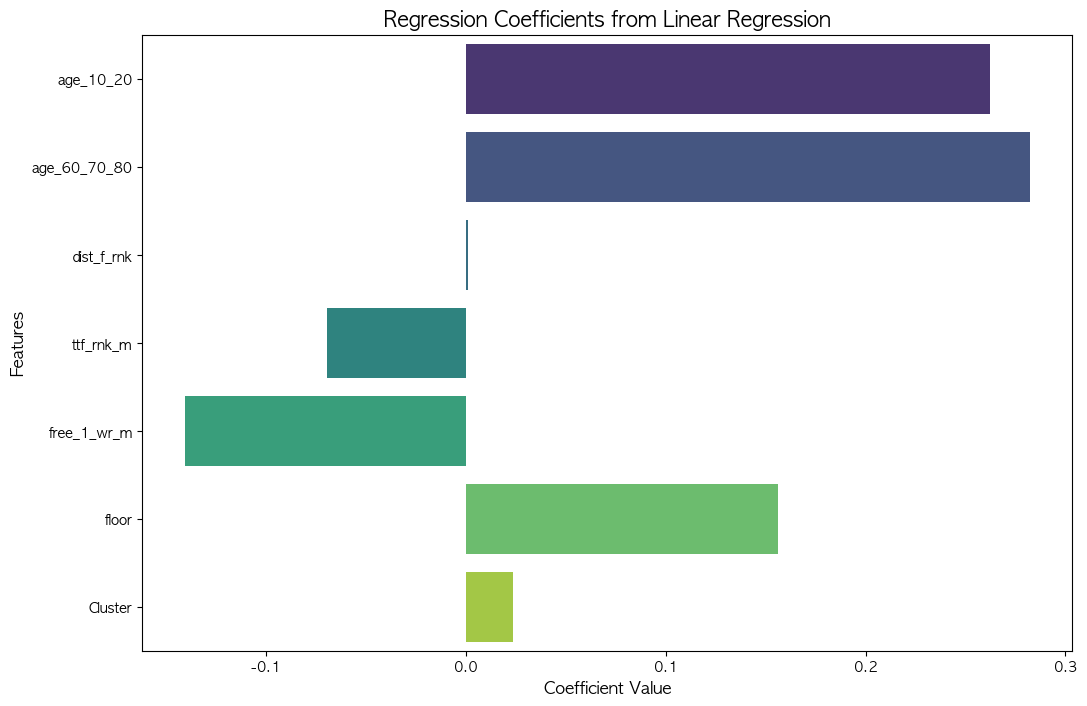

{'regression_coefficients': array([ 0.26211952,  0.28237248,  0.00084324, -0.06936771, -0.14071005,
       -0.14071005,  0.15624631,  0.02372659]), 'mean_diff_between_intervals': 0.043886815602311724, 'mse_value': 0.00531074502113074, 'rmse_value': 0.07287485863540827, 'mae_value': 0.054687487236855827, 'r2_value': 0.7735256874426051}


In [418]:
X = seat_scaled_df_2.drop(columns=['seat','x','y','percent_q75','book_cnt'])
y = seat_scaled_df_2['book_cnt']

y_pred_b_2 = linear_regression_model(X,y)

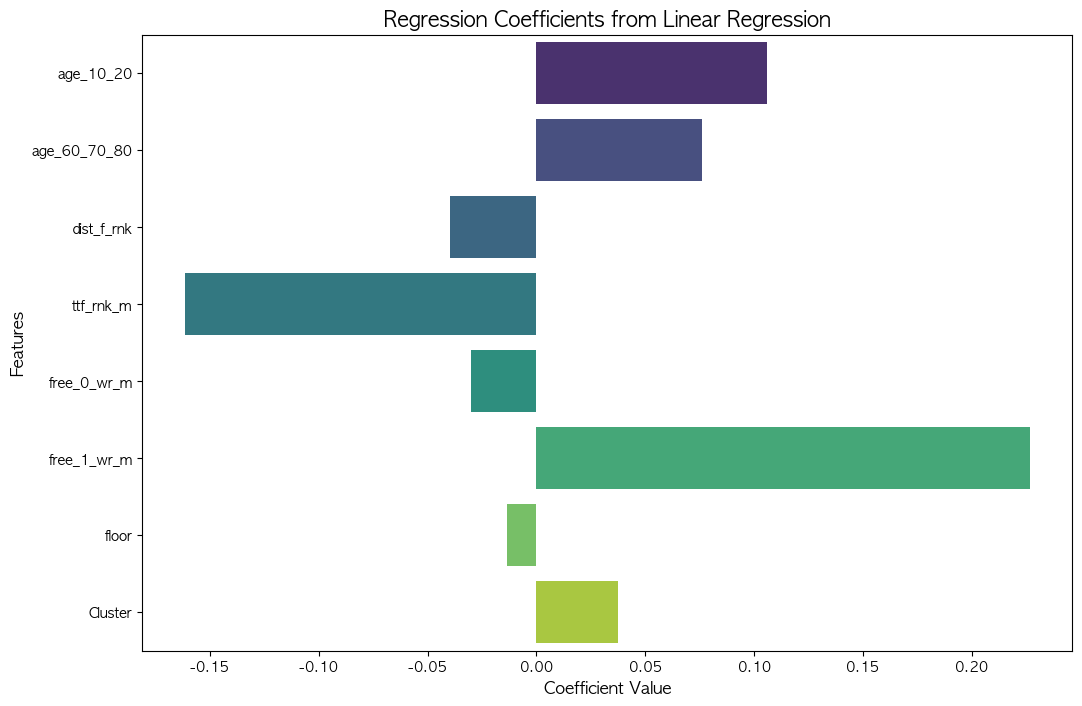

{'regression_coefficients': array([ 0.10600911,  0.07591873, -0.03961134, -0.16151448, -0.02983767,
        0.22668537, -0.01343899,  0.03725886]), 'mean_diff_between_intervals': 0.05935665152004416, 'mse_value': 0.0060875802538330834, 'rmse_value': 0.07802294696967735, 'mae_value': 0.06112676394324559, 'r2_value': 0.4393157311398429}


In [419]:
# 할인율
X = seat_scaled_df_0.drop(columns=['seat','x','y','percent_q75','book_cnt'])
y = seat_scaled_df_0['percent_q75']

y_pred_d_1 = linear_regression_model(X,y)

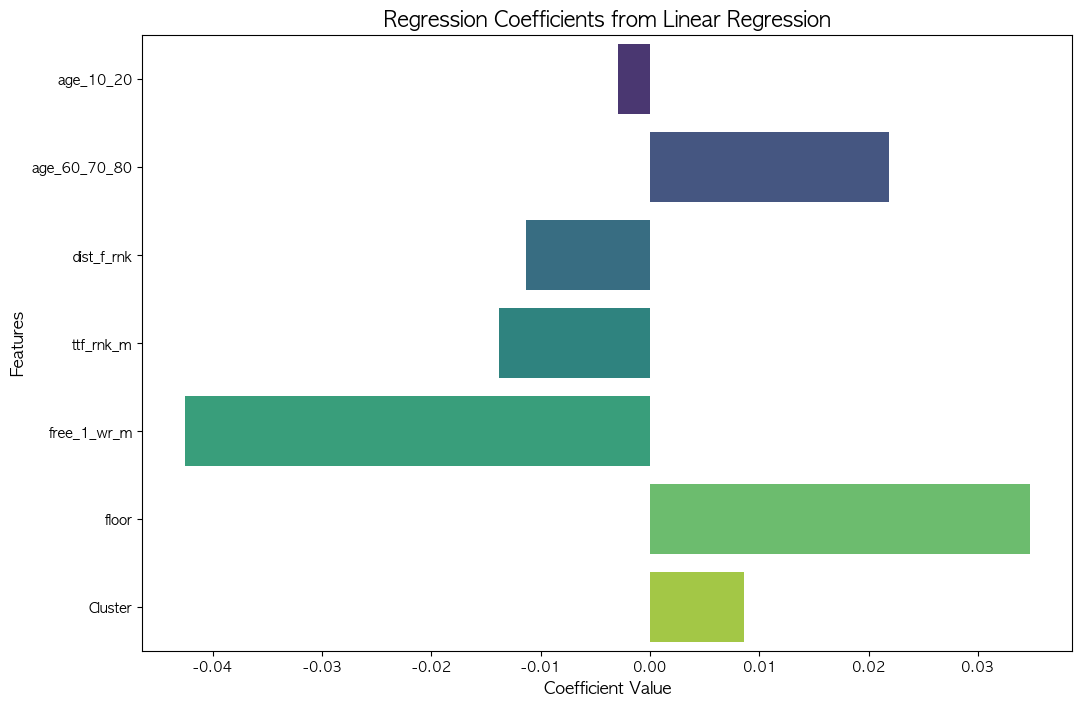

{'regression_coefficients': array([-0.00292282,  0.02182393, -0.01138142, -0.01383372, -0.04257452,
       -0.04257452,  0.03477737,  0.00862814]), 'mean_diff_between_intervals': 0.03709095338038369, 'mse_value': 0.0028437005549549472, 'rmse_value': 0.05332635891334554, 'mae_value': 0.037291697669344405, 'r2_value': 0.1605948958895118}


In [420]:
X = seat_scaled_df_1.drop(columns=['seat','x','y','percent_q75','book_cnt'])
y = seat_scaled_df_1['percent_q75']

y_pred_d_1 = linear_regression_model(X,y)

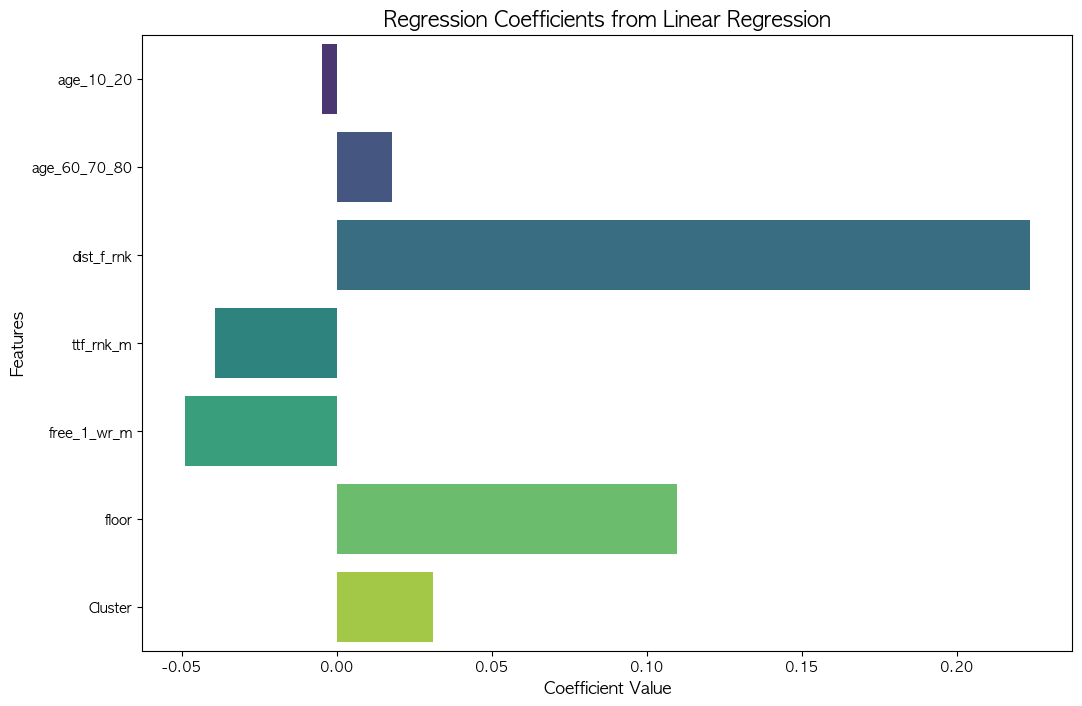

{'regression_coefficients': array([-0.00473326,  0.01793922,  0.22368071, -0.03944947, -0.04910534,
       -0.04910534,  0.10983255,  0.03112327]), 'mean_diff_between_intervals': 0.08048899442988997, 'mse_value': 0.01664978453081808, 'rmse_value': 0.1290340440768175, 'mae_value': 0.10536099461667872, 'r2_value': 0.2608868459877476}


In [421]:
# 할인율
X = seat_scaled_df_2.drop(columns=['seat','x','y','percent_q75','book_cnt'])
y = seat_scaled_df_2['percent_q75']

y_pred_d_2 = linear_regression_model(X,y)

In [422]:
# 0번 대분류에 대한 가격 선정 모델

# 예매율 Final
X = seat_scaled_df_0.drop(columns=['seat','x','y','percent_q75','book_cnt'])
y = seat_scaled_df_0['book_cnt']

Final_B_coeff, F_B_co = linear_regression_model_Fianl(X,y)


# 할인율 Final

X = seat_scaled_df_0.drop(columns=['seat','x','y','percent_q75','book_cnt'])
y = seat_scaled_df_0['percent_q75']

Final_D_coeff, F_D_co = linear_regression_model_Fianl(X,y)

final_b_df = pd.DataFrame({'appreciation': Final_B_coeff})
final_d_df = pd.DataFrame({'depreciation': Final_D_coeff})

new_cost_0 = pd.concat([seat_scaled_df_0[['seat','Cluster']],final_b_df,final_d_df],axis=1)
new_cost_0



seat  Cluster  appreciation  depreciation
0      1층 A블록10열 1        4      0.277456      0.222063
1     1층 A블록10열 10        5      0.383031      0.318465
2     1층 A블록10열 11        5      0.484391      0.313902
3      1층 A블록10열 2        4      0.238609      0.215749
4      1층 A블록10열 3        4      0.251604      0.225070
...            ...      ...           ...           ...
2460   합창석 H블록4열 5        2      0.137335      0.154567
2461   합창석 H블록4열 6        2      0.163411      0.121312
2462   합창석 H블록4열 7        2      0.131243      0.172680
2463   합창석 H블록4열 8        2      0.095129      0.176946
2464   합창석 H블록4열 9        2      0.071074      0.200279

[2465 rows x 4 columns]

In [423]:
# 1번 대분류에 대한 가격 선정 모델

# 예매율 Final
X = seat_scaled_df_1.drop(columns=['seat','x','y','percent_q75','book_cnt'])
y = seat_scaled_df_1['book_cnt']

Final_B_coeff, F_B_co = linear_regression_model_Fianl(X,y)


# 할인율 Final

X = seat_scaled_df_1.drop(columns=['seat','x','y','percent_q75','book_cnt'])
y = seat_scaled_df_1['percent_q75']

Final_D_coeff, F_D_co = linear_regression_model_Fianl(X,y)

final_b_df = pd.DataFrame({'appreciation': Final_B_coeff})
final_d_df = pd.DataFrame({'depreciation': Final_D_coeff})

new_cost_1 = pd.concat([seat_scaled_df_1[['seat','Cluster']],final_b_df,final_d_df],axis=1)
new_cost_1



seat  Cluster  appreciation  depreciation
0      1층 A블록10열 1        4      0.225219      0.100219
1     1층 A블록10열 10        5      0.394886      0.144181
2     1층 A블록10열 11        5      0.486832      0.159975
3      1층 A블록10열 2        4      0.230635      0.103052
4      1층 A블록10열 3        4      0.263644      0.114637
...            ...      ...           ...           ...
2460   합창석 H블록4열 5        3      0.144393      0.108939
2461   합창석 H블록4열 6        3      0.153157      0.114735
2462   합창석 H블록4열 7        3      0.152638      0.107307
2463   합창석 H블록4열 8        3      0.136629      0.105336
2464   합창석 H블록4열 9        3      0.136512      0.107761

[2465 rows x 4 columns]

In [424]:
# 2번 대분류에 대한 가격 선정 모델

# 예매율 Final


X = seat_scaled_df_2.drop(columns=['seat','x','y','percent_q75','book_cnt'])
y = seat_scaled_df_2['book_cnt']

Final_B_coeff, F_B_co = linear_regression_model_Fianl(X,y)


# 할인율 Final

X = seat_scaled_df_2.drop(columns=['seat','x','y','percent_q75','book_cnt'])
y = seat_scaled_df_2['percent_q75']

Final_D_coeff, F_D_co = linear_regression_model_Fianl(X,y)

final_b_df = pd.DataFrame({'appreciation': Final_B_coeff})
final_d_df = pd.DataFrame({'depreciation': Final_D_coeff})

new_cost_2 = pd.concat([seat_scaled_df_2[['seat','Cluster']],final_b_df,final_d_df],axis=1)
new_cost_2



seat  Cluster  appreciation  depreciation
0      1층 A블록10열 1        4      0.254421      0.417682
1     1층 A블록10열 10        5      0.371825      0.404948
2     1층 A블록10열 11        5      0.449652      0.406760
3      1층 A블록10열 2        4      0.266012      0.414639
4      1층 A블록10열 3        4      0.240094      0.395075
...            ...      ...           ...           ...
2460   합창석 H블록4열 5        3      0.149718      0.188608
2461   합창석 H블록4열 6        3      0.128740      0.183105
2462   합창석 H블록4열 7        3      0.163026      0.189956
2463   합창석 H블록4열 8        3      0.128128      0.183326
2464   합창석 H블록4열 9        3      0.121922      0.183311

[2465 rows x 4 columns]

In [425]:
## 활용 예시 
# 공연 특성 반영 분류에서 genre 0번에 해당하는 하나의 공연을 대상으로 위 가격 선정 모델 적용

data_ex = data[data['id']=='2631_2022-12-27']
data_ex = data_ex.groupby('seat')['cost'].mean().reset_index()
new_cost_0_try = new_cost_0.merge(data_ex,on=['seat'],how = 'left') 
new_cost_0_try

seat  Cluster  appreciation  depreciation      cost
0      1층 A블록10열 1        4      0.277456      0.222063       NaN
1     1층 A블록10열 10        5      0.383031      0.318465       NaN
2     1층 A블록10열 11        5      0.484391      0.313902  170000.0
3      1층 A블록10열 2        4      0.238609      0.215749       NaN
4      1층 A블록10열 3        4      0.251604      0.225070  170000.0
...            ...      ...           ...           ...       ...
2460   합창석 H블록4열 5        2      0.137335      0.154567   80000.0
2461   합창석 H블록4열 6        2      0.163411      0.121312   80000.0
2462   합창석 H블록4열 7        2      0.131243      0.172680   80000.0
2463   합창석 H블록4열 8        2      0.095129      0.176946   80000.0
2464   합창석 H블록4열 9        2      0.071074      0.200279       NaN

[2465 rows x 5 columns]

In [426]:
new_cost_0_try['new_cost'] = new_cost_0_try['cost'] * (1 + (new_cost_0_try['appreciation'] - new_cost_0_try['depreciation']))

In [427]:
new_cost_0_try

seat  Cluster  appreciation  depreciation      cost  \
0      1층 A블록10열 1        4      0.277456      0.222063       NaN   
1     1층 A블록10열 10        5      0.383031      0.318465       NaN   
2     1층 A블록10열 11        5      0.484391      0.313902  170000.0   
3      1층 A블록10열 2        4      0.238609      0.215749       NaN   
4      1층 A블록10열 3        4      0.251604      0.225070  170000.0   
...            ...      ...           ...           ...       ...   
2460   합창석 H블록4열 5        2      0.137335      0.154567   80000.0   
2461   합창석 H블록4열 6        2      0.163411      0.121312   80000.0   
2462   합창석 H블록4열 7        2      0.131243      0.172680   80000.0   
2463   합창석 H블록4열 8        2      0.095129      0.176946   80000.0   
2464   합창석 H블록4열 9        2      0.071074      0.200279       NaN   

           new_cost  
0               NaN  
1               NaN  
2     198983.116585  
3               NaN  
4     174510.707644  
...             ...  
2460   78621.383435  
2461   83367.903994  
2462   76684.993279  
2463   73454.588252  
2464            NaN  

[2465 rows x 6 columns]

In [428]:
new_cost_0_try_cluster  = new_cost_0_try.groupby('Cluster')['new_cost'].mean().reset_index()
new_cost_0_try_cluster['new_cost'] = new_cost_0_try_cluster['new_cost'].astype(int) 

In [429]:
new_cost_0_try_cluster

Cluster  new_cost
0        1     90017
1        2     61837
2        3    156474
3        4    198802
4        5    246467
5        6    287844

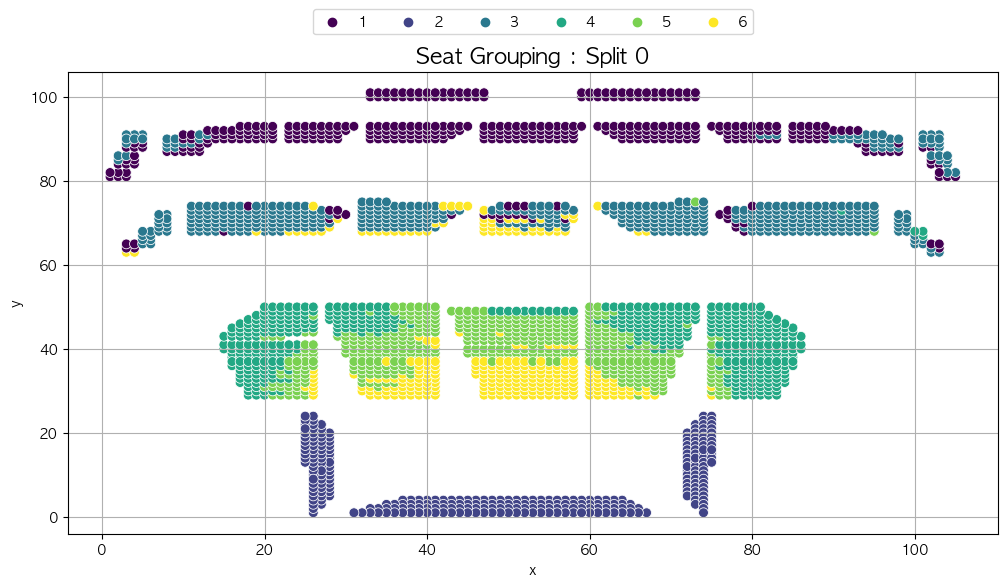

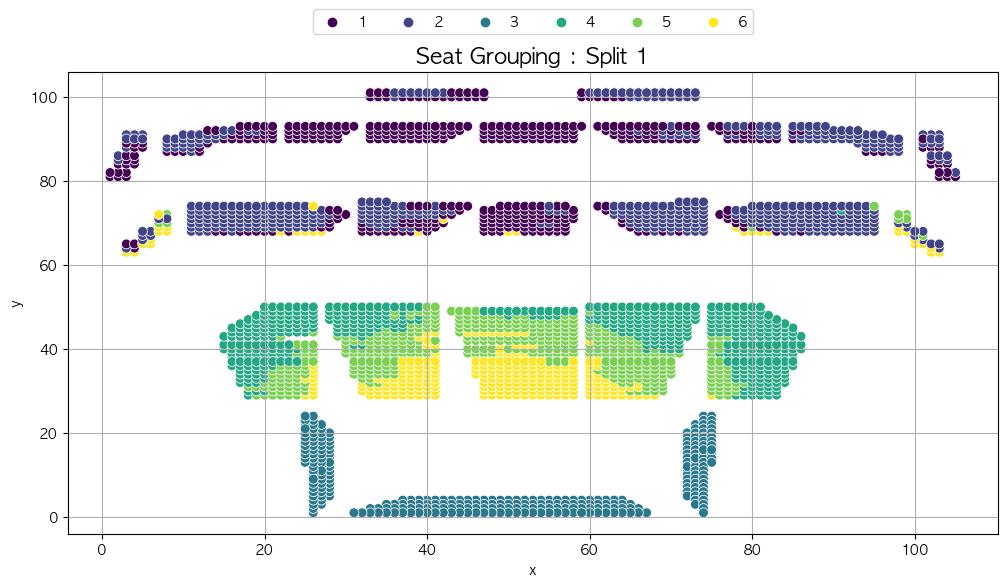

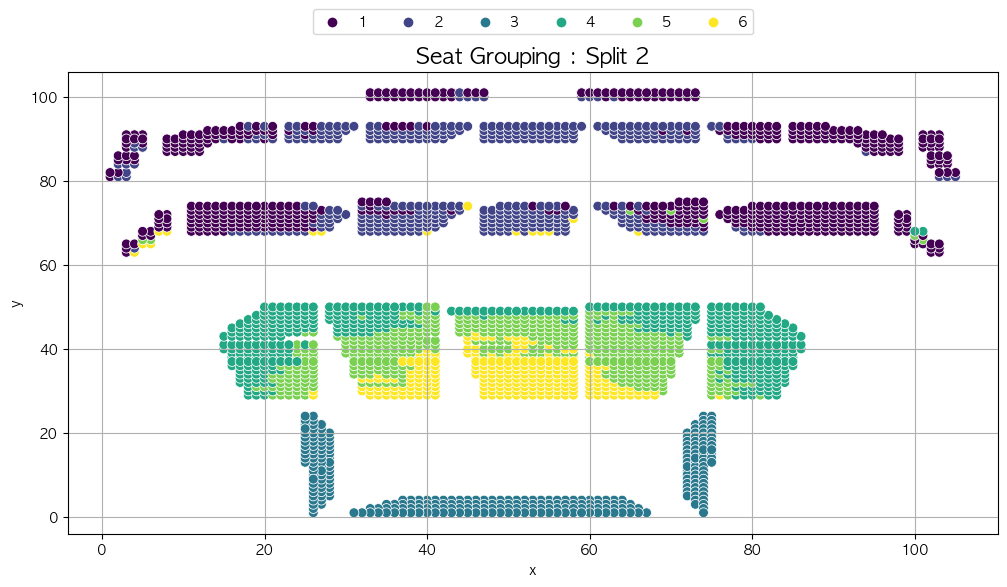

In [430]:
Visualize_SeatClustering()